# Trying to fit to the MSSFR from TNG

In [2]:
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck18  as cosmo# Planck 2018
from astropy.cosmology import z_at_value

from astropy.table import Table, Column
import os

import matplotlib
from pylab import *
from matplotlib import ticker, cm

def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass    
   
save_loc    =  '/Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/'
    
proj_dir    = '/Volumes/TOSHIBA_EXT/'#'/n/de_mink_lab/Users/lvanson/'
base_dir    = proj_dir+'/CompasOutput/'
data_dir    = base_dir+ '/v02.17.18/N1e6_CoolWind_fWR_LBV/'#'/N1e6_CoolWind_fWR/'#'/N1e5_fWR_CoolWind_LBVpresc/'  #'N1e5_fWR_allWind/'#'Ne7Grid_alpha01_10_fWR01_10/'

TNGlocation = '/Users/lieke/surfdrive/Documents/CompareCOMPAS/'

plt.rc('font', family='serif')

##PLOT setttings
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize




# Function to read a simulation (with lazy params)

In [3]:

#########################################
#
#########################################
def read_data(loc = data_dir+'/output/COMPAS_Output_wWeights.h5', 
              rate_key = 'Rates_Z00.035_alpha%s_sigma0.39'%(-0.23), maxz=1.0):
    """
    Function to read the DCO and SYS data and add relevant columns and info needed to plot
    """
    
    def hdf5_to_astropy(hdf5_file, group = 'SystemParameters' ):
        """convert your hdf5 table to astropy.table for easy indexing etc
        hdf5_file  =  Hdf5 file you would like to convert
        group      =  Data group that you want to acces
        """
        Data         = hdf5_file[group]#
        table = Table()
        for key in list(Data.keys()):
            table[key] =  Data[key]
        return table

    
    print('Reading ',loc)
    ################################################
    ## Open hdf5 file
    File        = h5.File(loc ,'r')
    print(File.keys())
    ## Mask from DCO to merging BBH (W_i != 0 )
    DCO_mask   = File[rate_key]['DCO_mask'][()]
    redshifts = File[rate_key]['redshifts'][()]
    
    # Pour into astropy table
    DCO         = hdf5_to_astropy(File, group = 'DoubleCompactObjects' )  
    SYS         = hdf5_to_astropy(File, group = 'SystemParameters' )  
    
    ## Only sum your rates up to some max redshift 
    z_index = np.digitize(maxz, redshifts) -1
    print('max(redshift) in data', max(redshifts), '\n max redshift used: redshift[z_index]', redshifts[z_index])
    W_i        = File[rate_key]['merger_rate'][()]
    Weight     = np.sum(W_i[:,:z_index]/(1+redshifts[:z_index]), axis = 1)  
    W_io3      = File[rate_key]['detection_rateO3'][()]
    WeightO3   = np.sum(W_io3, axis = 1)

    ################################################
    ## Adding columns ##
    ################################################
    ## Adding columns ##
    SYS_DCO_seeds_bool          = np.in1d(SYS['SEED'], DCO['SEED']) #Bool to point SYS to DCO
    q_init                      = SYS['Mass@ZAMS(2)']/SYS['Mass@ZAMS(1)']
    DCO['q_init']               = q_init[SYS_DCO_seeds_bool]
    DCO['Stellar_Type@ZAMS(1)'] = SYS['Stellar_Type@ZAMS(1)'][SYS_DCO_seeds_bool]
    DCO['Stellar_Type@ZAMS(2)'] = SYS['Stellar_Type@ZAMS(2)'][SYS_DCO_seeds_bool]
    DCO['tDelay']               = DCO['Coalescence_Time'] + DCO['Time'] #Myr
    DCO['M_moreMassive']        = np.maximum(DCO['Mass(1)'], DCO['Mass(2)'])
    DCO['M_lessMassive']        = np.minimum(DCO['Mass(1)'], DCO['Mass(2)'])

    ################################################
    File.close()
    
    return SYS, DCO, DCO_mask, Weight, WeightO3


# SFR(z) Madau & Dickenson 2014 shape

In [4]:

########################################################
##
########################################################
def Madau_Dickinson2014(z, a=0.015, b=2.77, c=2.9, d=5.6):
    """
    default 'Neijssel et al 2019': a=0.01, b=2.77, c=2.9,  d=4.7
    Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2

    """
    dm_dtdMpc = a * (1 + z)**b/( 1 + ( (1+z)/c )**d ) *u.Msun *u.yr**-1 *u.Mpc**-3
    return dm_dtdMpc # Msun year-1 Mpc-3 

    

    

# SFR(z) Madau & Dickenson 2014 shape

max value 0.10372505357949298 solMass / (Mpc3 yr)  at x_max =  11.406496746978968 Gyr


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in multiply
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/SFR_tlookback.pdf


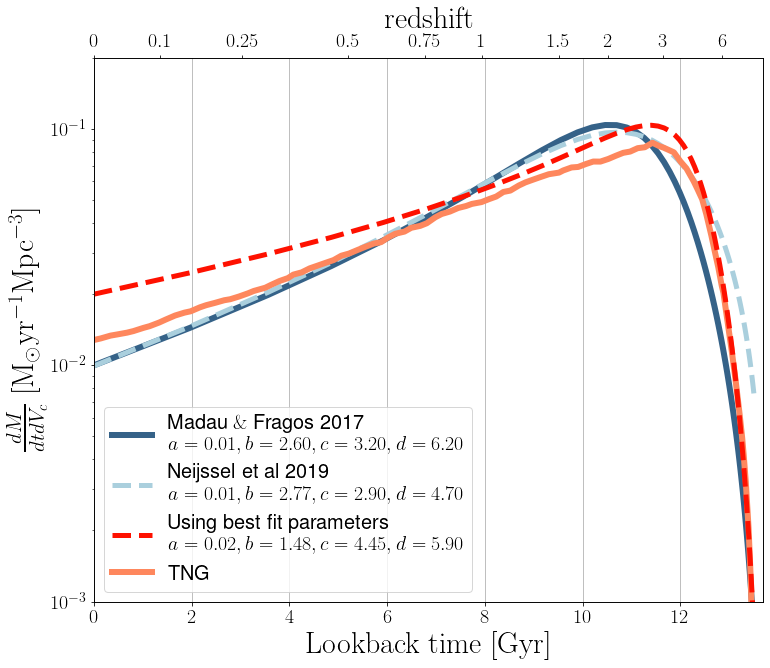

max value 0.10372505357949298 solMass / (Mpc3 yr)  at x_max =  2.7272727272727275


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: overflow encountered in exp
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in multiply
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/SFR_redshift.pdf


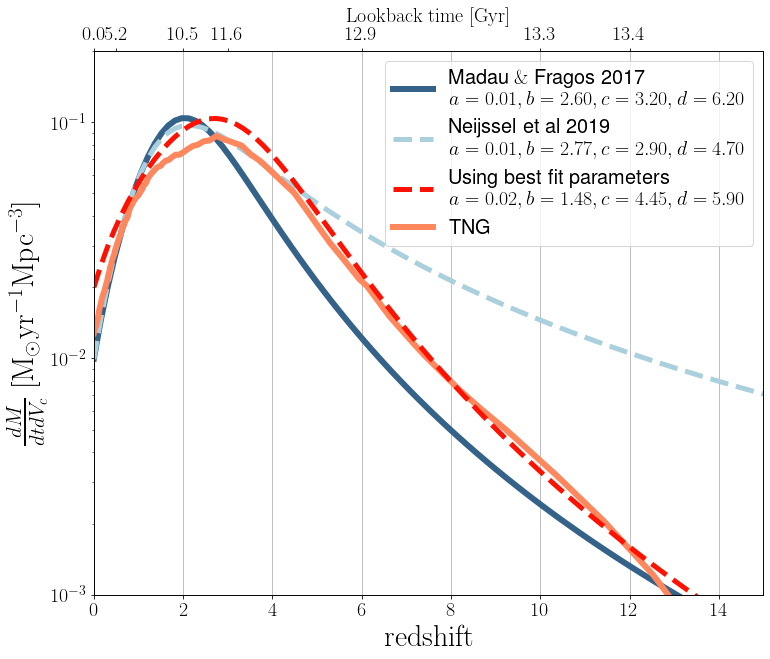

In [11]:

########################################################
# plot different SFRs
########################################################
def plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 13.7):
    ########################################################
    # Start plotting
    fig, ax = plt.subplots(figsize=(12,10))

    if x_redshift:
        x1  = redshift_list
    else:
        x1 = cosmo.lookback_time(redshift_list)


#     #default M&D 14
#     ax.plot(x1, Madau_Dickinson2014(redshift_list), 
#              label = 'Madau $\&$ Dickinson 2014\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.77,2.9,5.6)
#              , c = 'royalblue', ls = '--',lw=2)

    #default Madau & Fragos 17
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
             label = 'Madau $\&$ Fragos 2017\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
             , c = '#356288', ls = '-',lw=6)

    #default Coen
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
             label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
             , c = '#aacfdd', lw=5, ls = '--')


    # BEST FIT
    try:
        y_vals = Madau_Dickinson2014(redshift_list, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best)
        ax.plot(x1, y_vals,label = 'Using best fit parameters \n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a_best,sf_b_best,sf_c_best, sf_d_best), 
                 c = '#fe1100', lw=5, ls = '--', zorder =10)
        print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])
    except:
        print('you probably havent run the optimzation yet..')



    ######################################
    # read TNG data
    ######################################
    with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
    # Convert SFR from sfr/box to sfr Mpc-3
    littleh  = 0.6774
    Rbox     = 75/littleh
    TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
    TNG_SFRD = TNG_SFRD.value
    # the last value of Lookbacktimes = 0, which is problematic for z calculation
    redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
    redshifts_TNG.append(0) # put redshift zero back at the end
    redshifts_TNG = np.array(redshifts_TNG)
    redshifts_TNG_inc = redshifts_TNG[::-1]
    ##########################################
    # "observed" TNG SFR(z)
    ##########################################
    if x_redshift:
        xobs  = redshifts_TNG
    else:
        xobs = Lookbacktimes

    ax.plot(xobs, np.sum(TNG_SFRD,axis=1), label = 'TNG', c = '#fe875d', lw=6)

    # #######################
    # # Interpolated
    # x = Lookbacktimes #redshifts_TNG[::-1]
    # y = center_Zbin
    # z = TNG_SFRD # shape [increasing redshift, metal]
    # f_interp = interpolate.interp2d(x, y, z.T, kind='cubic')
    # # lets interpolate at regular z intervals
    # z_new    = np.arange(0, 10, 0.1)
    # xnew     = [cosmo.lookback_time(z).value for z in z_new]
    # ynew     = center_Zbin#np.logspace(-5, -0.5, num=50)

    # SFRDnew = f_interp(xnew,ynew)
    # print('np.shape(SFRDnew)', np.shape(SFRDnew) )
    # ax.plot(xnew, np.sum(SFRDnew,axis=0), label = 'TNG', c = 'green', lw=5, ls='--')


    ##########################################
    # Checking normalization of what I will fit
    ##########################################################################
    center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
    sfr = Madau_Dickinson2014(redshifts_TNG_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
    # Get dPdZ 
    dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                    skew_metallicity_distribution(muz =-0.1, mu_0 =0.025,
                                                  sigma_0=1.9,sigma_z=1.9, alpha =-1.7, 
                                                  metals=center_Zbin, redsh = redshifts_TNG_inc)
    if x_redshift:
        x  = redshifts
    else:
        x = cosmo.lookback_time(redshifts)

    # For each redshift in the TNG data:
    for redshift_i in range(len(redshifts)):
        SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ
#         plt.scatter(x[redshift_i], np.sum(SFRD), c = 'r')
        #
    ##########################################################################


    #### Age Universe Axis ####
    ax2 = ax.twiny()

    if x_redshift:
        ###################
        #Plotvalues
        ax.set_xlabel('$\mathrm{redshift}$', fontsize = 30)

        # Find loockback location for each of our redshifts
        redshift_tick_list = [0, 0.5, 2, 3, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
        # And annotate the tick labels :)
        ax2.set_xticks([z for z in redshift_tick_list])
        ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 20)

    else:
        ###################
        #Plotvalues
        ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
        
        redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
        # Find loockback location for each of our ages
        z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

        # And annotate the tick labels :)
        ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
        ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 30)


    ##########################################################################
    ax.xaxis.grid(5) # vertical lines
    # Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    logy = True
    if logy:
        plt.yscale('log')
    ax.set_ylabel(r'$\frac{dM}{dt dV_c}$ $\mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$', fontsize = 30)
    ax.set_ylim(1e-3, 0.2)
    ax.legend()
    if x_redshift:
        print('saving here', save_loc + 'SFR_redshift'+'.pdf')
        plt.savefig(save_loc + 'SFR_redshift'+'.pdf',  bbox_inches='tight')
    else:
        print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
        plt.savefig(save_loc + 'SFR_tlookback'+'.pdf',  bbox_inches='tight')
    
    plt.show()

    
# time axis
plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = False, tmin=0.0, tmax = 13.7)

# redshift axis
plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 15)


In [12]:
sf_a_best, sf_b_best, sf_c_best,  sf_d_best = 0.02, 1.48, 4.45, 5.90
# sf_a =0.01687063881834458, sf_b =1.4834054063851878, sf_c =4.448574027958166, sf_d =5.903964702985274

# muz =-0.048244647721407255, mu0 =0.024667742078400792, sigma_0 =1.1253850972905333, sigma_z =0.048072863682492945, alpha=-1.7671626767422142


# Get dP/dZ

metallicity density distribution


In [13]:
def get_metallicity_distribution(min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                 min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03),
                                 max_redshift = 10.0,redshift_step = 0.01,
                                 Z0=0.035, alpha=-0.23, sigma=0.39, s_factor = 0.0):
    """
    Calculate the distribution of metallicities at different redshifts using Neijssel+19 Eq.7-9
    (which is based on Madau & Dickinson 2014)

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution

    Args:
        redshifts          --> [list of floats] List of redshifts at which to calculate things
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        Z0                 --> [float]          Parameter used for calculating metallicity density dist
        alpha              --> [float]          Parameter used for calculating metallicity density dist
        sigma              --> [float]          Parameter used for calculating metallicity density dist
        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """
    ##################################
    redshifts = np.arange(0, max_redshift + redshift_step, redshift_step)

    ##################################
    # Experiment with redshift dependence sigma
    Sigma = sigma * 10**(s_factor * redshifts)
    
    # use Neijssel+19 Eq. 9 to find means
    mean_metallicities = Z0 * 10**(alpha * redshifts)
    mu_metallicities = np.log(mean_metallicities) - Sigma**2/2
    
    # create a range of metallicities
    log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
    metallicities = np.exp(log_metallicities)

    # use Neijessel+19 Eq. 7 to find probabilities (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 1./(Sigma[:,np.newaxis] * np.sqrt(2*np.pi)) * np.exp(-(log_metallicities - mu_metallicities[:,np.newaxis])**2 /(2 * Sigma[:,np.newaxis]**2) )
    
    # normalise the distribution
    norm = dPdlogZ.sum(axis=1) * step_logZ
    dPdlogZ = dPdlogZ / norm[:,np.newaxis]

    # assume a flat in log distribution in metallicity to find probability of drawing Z
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, redshifts, metallicities, p_draw_metallicity



# New log skewed distribution

## For the metallicity distribution :)

first let's try to implement the PDF
See also eq. 17 in : https://arxiv.org/ftp/arxiv/papers/1501/1501.02344.pdf


# (log) Skew normal dist: 

PDF of the skew normal is defined as:

\begin{equation}
f(Z) = 2 \phi \left(\frac{Z - \mu}{\sigma}\right) \Phi\left(\alpha \frac{Z - \mu}{\sigma} \right)
\end{equation}

$\phi(t)$ and $\Phi(t)$ are the standard ($\sigma = 1$) normal PDF and CDF respectively:

PDF of normal dist:
\begin{equation}
\phi \left(\frac{Z - \mu}{\sigma}\right)  = \frac{1}{\sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \left(\frac{Z - \mu}{\sigma}\right)^2}
\end{equation}

CDF of standard normal dist:
\begin{equation}
\Phi\left(\alpha \frac{Z - \mu}{\sigma} \right) =  \int_{-\infty}^{x} \phi(t) dt = 
\int_{-\infty}^{x = \left(\alpha \frac{Z - \mu}{\sigma} \right) } \frac{1}{\sqrt{2 \pi}} e^{\frac{-1}{2}t^2} dt
= \frac{1}{2} \left[ 1 + erf\left(\frac{x}{\sqrt{2}} \right) \right]
\end{equation}

The skew normal is a generalization of the normal distribution, that gets back to a normal distribution for $\alpha = 0$.


So the PDF of the skew-normal written out
\begin{equation}
f(Z) = \frac{2}{\sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \left(\frac{Z - \mu}{\sigma}\right)^2} 
\int_{-\infty}^{x = \left(\alpha \frac{Z - \mu}{\sigma} \right) } \frac{1}{\sqrt{2 \pi}} e^{\frac{-1}{2}t^2} dt
\end{equation}


***
The PDF for the **log-skew-normal** are then given by just substituting the random variable Z, with ln(Z)


\begin{equation}
f(Z) = 2 \phi(\frac{ln(Z) - \mu}{\sigma}) \Phi(\alpha \frac{ln(Z) - \mu}{\sigma})
\end{equation}

or written out explicitely:

\begin{equation}
f(Z) = \frac{2}{Z \sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \left(\frac{\ln(Z) - \mu}{\sigma}\right)^2} 
\int_{-\infty}^{x = \left(\alpha \frac{\ln(Z) - \mu}{\sigma} \right) } \frac{1}{\sqrt{2 \pi}} e^{\frac{-1}{2}t^2} dt
\end{equation}

or

\begin{equation}
f(Z) = \frac{2}{Z \sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \left(\frac{\ln(Z) - \mu}{\sigma}\right)^2} 
\frac{1}{2} \left[ 1 + erf\left(\frac{ \left(\alpha \frac{\ln(Z) - \mu}{\sigma} \right)  }{\sqrt{2}} \right) \right]
\end{equation}


The extra $1/Z$ factors in front of the PDFs come from 
\begin{equation}
\frac{dP}{dZ} = \frac{dP}{d\ln Z} \frac{d\ln Z}{dZ} = \frac{dP}{d\ln Z} \frac{1}{Z}
\end{equation}

***

## Moments
Moments of a probability distribution: the zeroth moment is the total probability (i.e. one), the first moment is the expected value, the second central moment is the variance, the third standardized moment is the skewness, and the fourth standardized moment is the kurtosis. 

equation 23) and 24) from : https://arxiv.org/ftp/arxiv/papers/1501/1501.02344.pdf
give the mean and variance of our log-skew-normally distributed random variable Z:


\begin{equation}
E(Z) = 2 e^{\mu} e^{\sigma^2 /2} \Phi(\beta \sigma)
\end{equation}


\begin{equation}
VAR(Z) = 2 e^{2\mu} e^{\sigma^2} (e^{\sigma^1} \Phi(2 \beta \sigma)  - 2\Phi(\beta \sigma)^2)
\end{equation}


with 
\begin{equation}
\beta = \frac{\alpha}{\sqrt{1 + \alpha^2} }
\end{equation}



In [14]:
def skew_metallicity_distribution(max_redshift = 10.0,redshift_step = 0.01,
                                  mu_0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048,alpha = -1.767,
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                  metals = [], redsh = [],
                                  min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03)):
                                 
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    that is basically a skew normal distribution, but then with the random variable x = ln(Z)

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu_0    = 0.035    --> [float]          location (mean in normal) for redshift 0
        muz = -0.23        --> [float]          redshift scaling of the location
        sigma_0 = 0.39     --> [float]          Scale (variance in normal)
        sigma_z = 0.39     --> [float]          Scale (variance in normal)
        alpha   = 0.0      --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """
    import scipy

    ##################################
    # the PDF of a standard normal distrtibution
    def normal_PDF(x):
        return 1./(np.sqrt(2* np.pi)) * np.exp(-(1./2) * (x)**2 )

    ##################################
    # the CDF of a standard normal distrtibution
    def normal_CDF(x):
        return 1./2. * (1 + scipy.special.erf(x/np.sqrt(2)) )
    
    ##################################
    if len(redsh) == 0:
        # Make redshifts
        redshifts = np.arange(0, max_redshift + redshift_step, redshift_step)
    else:
        redshifts = redsh
        
    ##################################
    # Experiment with redshift dependence sigma
    # LOG-LINEAR
    sigma = sigma_0* 10**(sigma_z*redshifts)
    #  LINEAR   sigma = sigma_z*redshifts + sigma_0
    
    ##################################
    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu_0 * 10**(muz * redshifts) 
    #print('np.shape(mean_metallicities)', np.shape(mean_metallicities))
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    #print(10*'*', 'BETA', beta)
    PHI  = normal_CDF(beta * sigma) # phi is now sigma x alpha dimentional
    #print('np.shape(PHI)', np.shape(PHI))
    
    mu_metallicities = np.log(mean_metallicities/2. * 1./(np.exp(0.5*sigma**2) * PHI )  ) 
    #print('np.shape(mu_metallicities)', np.shape(mu_metallicities))

    ##################################
    if len(metals) == 0:
        # create a range of metallicities (thex-values, or raandom variables)
        log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
        metallicities = np.exp(log_metallicities)
    else: 
        #use a pre-determined array of metals
        metallicities     = metals
        log_metallicities = np.log(metallicities)
        step_logZ         = np.diff(log_metallicities)
        step_logZ         = step_logZ[0]
        #print('step_logZ', step_logZ)

    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) * normal_PDF((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) * normal_CDF(alpha * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )
    #print('np.shape(dPdlogZ)', np.shape(dPdlogZ))


    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) #* step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]
    #print('NORMING', np.sum(dPdlogZ, axis = -1 )*step_logZ  )
    #print('np.shape(dPdlogZ)', np.shape(dPdlogZ))

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity



# Lets start calcuatiing chi^2

# First read the TNG data 
## And convert it to a SFDR in Msun/yr/Mpc^-3



In [16]:

######################################
# read TNG data
######################################
with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
    MetalBins     = f["MetalBins"][:]
    Lookbacktimes = f["Lookbacktimes"][:]
    BoxSfr        = f["Sfr"][:]
# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774
Rbox     = 75/littleh
TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
TNG_SFRD = TNG_SFRD.value

##########################################
# "observed" TNG metallicities that we use for our calculations
##########################################
center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
# Let's not use ALL metallicities in the TNG.. (they go waay too low!)
low_bound_Z_ind = np.where(center_Zbin > 1e-5)[0]# index of center_Zbin, where Z > 1e-5
tofit_TNG_metals = center_Zbin[low_bound_Z_ind]   


##########################################
# "obesrved" SFRD in TNG
##########################################
# flip redshifts around so they are in increasing order
TNG_SFRD_inc_z = TNG_SFRD[::-1, :]
tofit_TNG_SFRD = TNG_SFRD_inc_z[:,low_bound_Z_ind] 


##########################################
# The redshifts at which we will calc the log-skew-normal
##########################################
#### TNG redshifts corresponding to these lookback times ### 
# the last value of Lookbacktimes = 0, which is problematic for z calculation
redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
redshifts_TNG.append(0) # put redshift zero back at the end
redshifts_TNG = np.array(redshifts_TNG)
print('redshifts_TNG')  
print(['%.2f'% (z_fl) for  z_fl in redshifts_TNG[::-1] ] )
# print(np.diff(redshifts_TNG[::-1]), min(np.diff(redshifts_TNG[::-1])), max(np.diff(redshifts_TNG[::-1])))
    
reverse_lookback = Lookbacktimes[::-1]
# print('Reverse_lookback time: ')
# print(['%.2f'% (t_l) for  t_l in reverse_lookback ] )
# print(np.diff(reverse_lookback), min(np.diff(reverse_lookback)), max(np.diff(reverse_lookback)))


redshifts_TNG
['0.00', '0.01', '0.02', '0.03', '0.05', '0.06', '0.07', '0.08', '0.10', '0.11', '0.13', '0.14', '0.15', '0.17', '0.18', '0.20', '0.21', '0.23', '0.24', '0.26', '0.27', '0.30', '0.31', '0.33', '0.35', '0.36', '0.38', '0.40', '0.42', '0.44', '0.46', '0.48', '0.50', '0.52', '0.55', '0.58', '0.60', '0.62', '0.65', '0.68', '0.70', '0.73', '0.76', '0.79', '0.82', '0.85', '0.89', '0.92', '0.95', '1.00', '1.04', '1.08', '1.12', '1.16', '1.21', '1.25', '1.31', '1.36', '1.42', '1.50', '1.54', '1.61', '1.67', '1.75', '1.83', '1.91', '2.01', '2.11', '2.22', '2.33', '2.46', '2.59', '2.75', '2.91', '3.03', '3.31', '3.52', '3.74', '4.05', '4.22', '4.48', '4.72', '5.06', '5.30', '5.61', '5.94', '6.11', '6.62', '7.15', '7.40', '7.78', '8.22', '8.68', '9.28', '9.69', '10.35', '11.42', '12.53', '15.96', '22.11']


In [41]:
# What fraction of TNG metallicity happens below 10^-5
print('total SF happening in TNG', np.sum(TNG_SFRD))

higher_Z = np.where(center_Zbin > 1e-5)[0]# index of center_Zbin, where Z > 1e-5
print('Higher Z SF happening in TNG', np.sum(TNG_SFRD[:,higher_Z]))

lower_Z = np.where(center_Zbin <= 1e-5)[0]# index of center_Zbin, where Z <= 1e-5
print('Lower than 1e-5 Z SF happening in TNG', np.sum(TNG_SFRD[:,lower_Z]))

print('fraction happening below 1e-5',  np.sum(TNG_SFRD[:,lower_Z])/np.sum(TNG_SFRD) *100 ) 



total SF happening in TNG 3.6975867813633303
Higher Z SF happening in TNG 3.661207217925086
Lower than 1e-5 Z SF happening in TNG 0.0363795634382447
fraction happening below 1e-5 0.9838731472539303


# Interpolate the TNG data

Using scipy interpolate
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

f = interpolate.interp2d(x, y, z)



In [23]:

#########################################
x = Lookbacktimes[::-1] #redshifts_TNG[::-1]
y = tofit_TNG_metals
z = tofit_TNG_SFRD 
print('np.shape(x), np.shape(y), np.shape(z)', np.shape(x), np.shape(y), np.shape(z))

f_interp = interpolate.interp2d(x, y, z.T, kind='cubic')

# lets interpolate at regular redshift intervals
z_new    = np.arange(0, 10.1, 0.05)
# z_new = np.append(z_new, np.arange(3, 10, 0.01))
xnew     = [cosmo.lookback_time(z).value for z in z_new]
ynew     = tofit_TNG_metals #np.logspace(-5., -0.5, 100)#

SFRDnew = f_interp(xnew,ynew)

print('np.shape(xnew)', np.shape(xnew),'np.shape(ynew)', np.shape(ynew), 'np.shape(SFRDnew)', np.shape(SFRDnew) )


np.shape(x), np.shape(y), np.shape(z) (100,) (30,) (100, 30)
np.shape(xnew) (202,) np.shape(ynew) (30,) np.shape(SFRDnew) (30, 202)


In [49]:

##################################################
# muz =-0.09, mu0 =0.026, sigma =1.9, alpha=-3.3
##################################################
def calc_chi_square(fit_metals, Redshifts = redshifts_TNG[::-1],  observed_SFRD = tofit_TNG_SFRD,
                    mu_0_list = 0.026, muz_list =-0.09, sigma0_list = 1.9, sigmaz_list = 1.9, alpha_list =-3.3,
                    sf_a =0.01 , sf_b=2.6, sf_c=3.2 , sf_d=6.2, normed = False):
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    that is basically a skew normal distribution, but then with the random variable x = ln(Z)

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution

    Args:
        fit_metals              --> [float]          metals used for fitt
        Redshifts               --> [float]          redshihts used to fit
        observed_SFRD           --> [float]          'observed' SFRD to fit to
        
        mu_0_list    = -0.23    --> [float]          location (mean in normal) at redshift 0
        muz_list = 0.035    --> [float]          redshift evolution of the location
        sigma0_list  = 0.39     --> [float]          Scale at redshift 0 (variance in normal)
        sigmaz_list  = 0.0      --> [float]          redshift evolution of Scale (variance in normal)
        alpha_list   = 0.0      --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        sf_a                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_b                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_c                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_d                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)

    Returns:
        tot_chi_square          --> [float ] 
    """
    
    """
    ######################################

    """  
    print('muz_list', muz_list, 'mu_0_list',mu_0_list, 'sigma0_list',sigma0_list,'sigmaz_list',sigmaz_list, 'alpha_list',alpha_list,
          'sf_a', sf_a, 'sf_b', sf_b, 'sf_c', sf_c, 'sf_d', sf_d)
        
    #####################################
    # Get the SFR
    # Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2
    sfr = Madau_Dickinson2014(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d) # Msun year-1 Mpc-3 

    # Get dPdZ 
    dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                    skew_metallicity_distribution(muz = muz_list, mu_0 = mu_0_list,
                                                  sigma_0= sigma0_list, sigma_z=sigmaz_list, alpha = alpha_list, 
                                                  metals=fit_metals, redsh = Redshifts)

    #print('np.shape(fit_metals)', np.shape(fit_metals),'np.shape(dPdlogZ)', np.shape(dPdlogZ))
    
    ######################################
    # For each redshift in the TNG data:
    tot_chi_square = 0
    #np.zeros((len(muz_list), len(mu_0_list), len(sigma_list), len(alpha_list)) )
        
    for redshift_i in range(len(redshifts)):
        #print(redshift_i, 'at redshift', redshifts[redshift_i])
        ######################################
        # Now the SFRD = sfr x dPdZ
        #print('sfr[redshift_i]',sfr[redshift_i])
        SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:] 
        #/p_draw_metallicity# Msun year-1 Mpc-3 

        ###################
        if normed:
            obs_norm = np.sum(observed_SFRD[redshift_i,:])
            obs = observed_SFRD[redshift_i,:]/obs_norm
            #print('np.sum(obs)', np.sum(obs))
            
            #model is normed in logZ, so multiply by logZ-binwidth
            model = dPdlogZ[redshift_i,:] *step_logZ 
            #print('np.sum(model)', np.sum(model).flatten() )

        else:
            obs = observed_SFRD[redshift_i,:] 
            #print('step_logZ', step_logZ)
            model = SFRD.value 
        #print('obs', np.shape(obs) , 'model', np.shape(model) )
        
        ###################
        # Zero values are troublesome in Chi_squared!
        # only fit where obs > 1e-8  
        common_bool = np.logical_and(model > 1e-11, obs > 1e-11)
        model = model[common_bool]
        obs   = obs[common_bool]

        ###################
        # Actual CHI_squared
        #chi_square = ((np.log10(obs) - np.log10(model) )**2)#/np.sum(model) 
        chi_square = ((obs - model )**2)/np.sum(model) 
        #print('chi_square', chi_square, np.sum(chi_square, axis = -1))
        #/np.sum(model)  = divide by the sfr at this redshift
        
        #/sfr[redshift_i].value #/model 
        #print('chi_square', chi_square )
        tot_chi_square += np.sum(chi_square, axis = -1)
        #print('tot_chi_square', np.shape(tot_chi_square), tot_chi_square )


    ######################################
    # Minimum Chi_squared taking all redshift into aaccount
    print(tot_chi_square)
    
    return tot_chi_square
#     return chi_square_matix, muz_list[ind[0]], mu_0_list[ind[1]], sigma_list[ind[2]], alpha_list[ind[3]]


    
    

# Run your chi square calculations

## and leave the refinement up to scipy minimize

In [50]:
'''
default 'Neijssel et al 2019': a=0.01, b=2.77, c=2.9,  d=4.7
Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2

z_new = np.arange(0, 10, 0.001)
xnew = [cosmo.lookback_time(z).value for z in z_new]
ynew = np.logspace(-5, -0.5, num=50)

SFRDnew = f(xnew,ynew)
'''

#################################################################
## Function wrapper to minimize the Chi_square
#################################################################
def test_chi(x0 = [-0.09, 0.026, 1.9, 0.1, -3.3,0.01, 2.6, 3.2, 6.2] ):

# Interpolated TNG data
    chi_square_matix = calc_chi_square(ynew, Redshifts = z_new, observed_SFRD = SFRDnew.T, 
                                       muz_list =x0[0], mu_0_list =x0[1],sigma0_list =x0[2], sigmaz_list=x0[3], alpha_list =x0[4],
                                       sf_a =x0[5], sf_b=x0[6], sf_c=x0[7], sf_d=x0[8],
                                       normed = False)

# Pure TNG data
#     chi_square_matix = calc_chi_square(fit_metals=tofit_TNG_metals, Redshifts = redshifts_TNG[::-1], observed_SFRD = tofit_TNG_SFRD, 
#                                        muz_list =x0[0], mu_0_list =x0[1], sigma_list =x0[2], alpha_list =x0[3],
# #                                        sf_a =0.01, sf_b=2.6, sf_c=3.2, sf_d=6.2,
#                                        sf_a =x0[4], sf_b=x0[5], sf_c=x0[6], sf_d=x0[7],
#                                        normed = False)
    
    return chi_square_matix


# BEST GUESS
x0 = np.array([-0.15, 0.026, 1.1, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2])
# FIT
res = minimize(test_chi, x0= x0, method ='nelder-mead')

# BOUNDS=[(-0.3, -0.01), (0.01, 0.035), (0.5, 3.5), (-2.5, -0.1), (0.009, 0.011), (2.5,2.7), (1., 5), (1, 9)] 
# res = minimize(test_chi, x0= x0, method ='Powell', bounds=BOUNDS)

print(res.x)




muz_list -0.15 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.1 alpha_list -3.3 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.2179225819338669
muz_list -0.1575 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.1 alpha_list -3.3 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.23025730020014734
muz_list -0.15 mu_0_list 0.0273 sigma0_list 1.1 sigmaz_list 0.1 alpha_list -3.3 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.20876976349763615
muz_list -0.15 mu_0_list 0.026 sigma0_list 1.1550000000000002 sigmaz_list 0.1 alpha_list -3.3 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.2228759140886872
muz_list -0.15 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.10500000000000001 alpha_list -3.3 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.22425448591948693
muz_list -0.15 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.1 alpha_list -3.465 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.21321217639476553
muz_list -0.15 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.1 alpha_list -3.3 sf_a 0.0105 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.21010213307387773
muz_list -0.

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


0.16349779979292495
muz_list -0.1477960300390823 mu_0_list 0.027050559014704042 sigma0_list 1.1038736441737331 sigmaz_list 0.09953249122041133 alpha_list -3.3518587011540335 sf_a 0.009792950048390441 sf_b 2.705055901470407 sf_c 3.3292995710404956 sf_d 5.824223121663558
0.15416660521619172
muz_list -0.1473062589366562 mu_0_list 0.025695127684638264 sigma0_list 1.1047344539901185 sigmaz_list 0.09942860038050275 alpha_list -3.363382856966042 sf_a 0.010246938948032762 sf_b 2.7284016573527192 sf_c 3.3580328090494946 sf_d 5.740717148699903
0.1949761811771938
muz_list -0.14797969420249213 mu_0_list 0.026096345763478697 sigma0_list 1.103550840492589 sigmaz_list 0.09957145028537705 alpha_list -3.3475371427245313 sf_a 0.010185204211024573 sf_b 2.696301243014539 sf_c 3.3185246067871215 sf_d 5.855537861524928
0.16665959391830296
muz_list -0.14685730209276557 mu_0_list 0.027016537854300197 sigma0_list 1.1055235296551382 sigmaz_list 0.09933336711058655 alpha_list -3.373946666460381 sf_a 0.0102880954

0.10296198107112885
muz_list -0.14117961648395685 mu_0_list 0.028567804557730805 sigma0_list 1.112267850218366 sigmaz_list 0.10110121956685492 alpha_list -3.9862536024315434 sf_a 0.010083013797552264 sf_b 2.3206747105768213 sf_c 3.4123955859189072 sf_d 5.097449767467947
0.10058146803314079
muz_list -0.13694330728874415 mu_0_list 0.029719766466377216 sigma0_list 1.1251438727186496 sigmaz_list 0.09664896583339153 alpha_list -4.1085899451097045 sf_a 0.009749640864288051 sf_b 2.353795230018166 sf_c 3.4706712856885273 sf_d 4.827535940667909
0.0887959164554021
muz_list -0.13270692754518992 mu_0_list 0.030511838708529596 sigma0_list 1.1142698232926043 sigmaz_list 0.09779794081166977 alpha_list -4.008910779010986 sf_a 0.009802544415603548 sf_b 2.3594990988979383 sf_c 3.447305869504168 sf_d 5.028495469433432
0.07927447717926067
muz_list -0.1257682073018287 mu_0_list 0.03209044464696566 sigma0_list 1.1064710702348939 sigmaz_list 0.09640260011045462 alpha_list -4.119866521958689 sf_a 0.0097294776

0.06826201077798648
muz_list -0.1175871413014298 mu_0_list 0.032299454100712784 sigma0_list 1.0735744272534111 sigmaz_list 0.09244746685411914 alpha_list -4.36211967633117 sf_a 0.008922058647414058 sf_b 2.2985949688587253 sf_c 3.6597696588740622 sf_d 5.4245102752247885
0.06242759631446224
muz_list -0.12067823876082148 mu_0_list 0.03162969628665604 sigma0_list 1.1070272876890475 sigmaz_list 0.09199214217284964 alpha_list -4.130750886115499 sf_a 0.008874412714057287 sf_b 2.4045720854160684 sf_c 3.6016973707286355 sf_d 5.59914851252718
0.06353798292548558
muz_list -0.11641834592431463 mu_0_list 0.03223278243187608 sigma0_list 1.0767230719332015 sigmaz_list 0.08976093481251882 alpha_list -4.262838060168693 sf_a 0.008919386149717332 sf_b 2.381902330154663 sf_c 3.687438631822247 sf_d 5.565943888657139
0.06484765433357677
muz_list -0.11636007992642781 mu_0_list 0.03230815508595917 sigma0_list 1.074929089452886 sigmaz_list 0.09078783552027853 alpha_list -4.2931858839193655 sf_a 0.0088807596011

muz_list -0.11091170572720793 mu_0_list 0.03202338648705402 sigma0_list 1.1126202604740025 sigmaz_list 0.08840434196157437 alpha_list -4.315079114765053 sf_a 0.008439735574864552 sf_b 2.350749865783092 sf_c 3.7810383262693152 sf_d 5.90919470860036
0.05842357658782457
muz_list -0.11084682830158996 mu_0_list 0.03246688913744988 sigma0_list 1.103878854255554 sigmaz_list 0.08957867770584507 alpha_list -4.355641718877525 sf_a 0.008630160623611313 sf_b 2.320736898846161 sf_c 3.755148770198325 sf_d 5.646676484144342
0.05873356871238452
muz_list -0.10959521362917268 mu_0_list 0.032609333743297476 sigma0_list 1.1374618880586804 sigmaz_list 0.08799195934811455 alpha_list -4.320486695642629 sf_a 0.008686261988480371 sf_b 2.3720961481533633 sf_c 3.7162055721021128 sf_d 5.72575933242055
0.05906504959123845
muz_list -0.10689245961460848 mu_0_list 0.032988420475728 sigma0_list 1.1115150227194361 sigmaz_list 0.08754316697583506 alpha_list -4.364559689618259 sf_a 0.00866652086596051 sf_b 2.324940821492

0.05317382681397981
muz_list -0.10237499507962858 mu_0_list 0.030490997826581448 sigma0_list 1.1377155659273752 sigmaz_list 0.0874436019466894 alpha_list -4.3762001179155146 sf_a 0.008838720455086393 sf_b 2.1854445956774766 sf_c 4.021829387029997 sf_d 6.092230936074449
0.052345830789184415
muz_list -0.10164139660033339 mu_0_list 0.029468547240768667 sigma0_list 1.136553706033291 sigmaz_list 0.08705119918681786 alpha_list -4.398890005850834 sf_a 0.008780367828633562 sf_b 2.15248185154816 sf_c 4.104174788710685 sf_d 6.28212351664089
0.052101529338024484
muz_list -0.09585326524331765 mu_0_list 0.031020348737646752 sigma0_list 1.1556698619901868 sigmaz_list 0.08544391988131228 alpha_list -4.386835441148219 sf_a 0.008991993766200308 sf_b 2.1328748000399846 sf_c 4.104522135295829 sf_d 6.1118833956691745
0.05224498432003719
muz_list -0.09997488697228435 mu_0_list 0.0304275418503049 sigma0_list 1.1236047738815715 sigmaz_list 0.08842703824711023 alpha_list -4.47491777984254 sf_a 0.0091132124564

0.04211720034913528
muz_list -0.07777513558507146 mu_0_list 0.02576062861553377 sigma0_list 1.1658652816831787 sigmaz_list 0.08709206098676403 alpha_list -4.341335537500768 sf_a 0.013135128095245144 sf_b 1.648926584141285 sf_c 4.595098932711343 sf_d 5.997499434654214
0.03796088399524589
muz_list -0.0725024348603105 mu_0_list 0.02552324661499765 sigma0_list 1.1451621338084585 sigmaz_list 0.08680342853080819 alpha_list -4.418470199296895 sf_a 0.013728995139526662 sf_b 1.575161693304036 sf_c 4.672507233960099 sf_d 5.939877256235697
0.03797803170776864
muz_list -0.08547327169758329 mu_0_list 0.028267443682440947 sigma0_list 1.1260688607780307 sigmaz_list 0.0903739660309579 alpha_list -4.296156092064658 sf_a 0.012657844590406787 sf_b 1.744703557870153 sf_c 4.345540021661547 sf_d 5.541407205767502
0.04283850196237447
muz_list -0.08144685516091016 mu_0_list 0.02514039195549822 sigma0_list 1.205745116222207 sigmaz_list 0.08625287171209389 alpha_list -4.263099160000472 sf_a 0.012579848906295411

0.034966883064969735
muz_list -0.07271614417327632 mu_0_list 0.025167790470706112 sigma0_list 1.14566107535635 sigmaz_list 0.08572536322525622 alpha_list -4.208072886455825 sf_a 0.015414538181500154 sf_b 1.544631610599117 sf_c 4.626145682056052 sf_d 6.125679970569749
0.0332465616061138
muz_list -0.06193477703421321 mu_0_list 0.02442240351571639 sigma0_list 1.1827456112070776 sigmaz_list 0.08341522065497053 alpha_list -3.971665107629958 sf_a 0.018192524327240937 sf_b 1.373722304194068 sf_c 4.768853343084189 sf_d 6.149917439011446
0.031324982096982604
muz_list -0.05552675518734537 mu_0_list 0.024537617141821136 sigma0_list 1.2118340887429904 sigmaz_list 0.08132486614824463 alpha_list -3.7945613145201165 sf_a 0.019684631291428695 sf_b 1.2985880008327664 sf_c 4.829960950521119 sf_d 6.207578716655366
0.031535852735447796
muz_list -0.0646683815038896 mu_0_list 0.02555657960853218 sigma0_list 1.141461380779905 sigmaz_list 0.08360271943553302 alpha_list -4.239780882287912 sf_a 0.01668227446508

0.031018198987793958
muz_list -0.06193939511101135 mu_0_list 0.023524944976070154 sigma0_list 1.181868020678495 sigmaz_list 0.08381369979950304 alpha_list -4.035923910986658 sf_a 0.018397135598740143 sf_b 1.3320785326110363 sf_c 4.787367867817537 sf_d 6.1235787050330455
0.031697390799528394
muz_list -0.05994355088433255 mu_0_list 0.02384757187526751 sigma0_list 1.1701929671614328 sigmaz_list 0.08254101506003453 alpha_list -4.059057793875157 sf_a 0.018461197858812683 sf_b 1.3501881239195264 sf_c 4.79761540763881 sf_d 6.301373768807884
0.030978144163190786
muz_list -0.05423954063177722 mu_0_list 0.023679597022315764 sigma0_list 1.1855912889836668 sigmaz_list 0.08193621325220692 alpha_list -3.947976632456947 sf_a 0.01990824075698864 sf_b 1.2616110000461485 sf_c 4.853081610471972 sf_d 6.196132983931994
0.03132912866140612
muz_list -0.05710443314112219 mu_0_list 0.023711954651039646 sigma0_list 1.180184104544069 sigmaz_list 0.08238467108387426 alpha_list -3.9953134490713373 sf_a 0.019241758

0.03080527533515075
muz_list -0.06022542938344806 mu_0_list 0.02354493103162173 sigma0_list 1.1781472869090797 sigmaz_list 0.08255780005248814 alpha_list -4.040829092165161 sf_a 0.01843589919916374 sf_b 1.3469590547922592 sf_c 4.808960240968021 sf_d 6.266517270054794
0.030675352169735028
muz_list -0.06199871776525154 mu_0_list 0.023537125743126233 sigma0_list 1.1663553652497844 sigmaz_list 0.08315809260934826 alpha_list -4.0758719306053734 sf_a 0.01805034217718659 sf_b 1.368350555364037 sf_c 4.792356325017714 sf_d 6.2288555096349985
0.03084068589324629
muz_list -0.05737149226091563 mu_0_list 0.02353603031173712 sigma0_list 1.20006752581724 sigmaz_list 0.08102726894915334 alpha_list -3.958787087867301 sf_a 0.019074311868760286 sf_b 1.3214637493841987 sf_c 4.833910053188534 sf_d 6.395075451001734
0.030668420920684666
muz_list -0.05622787628008899 mu_0_list 0.02352155260307298 sigma0_list 1.2103470798306892 sigmaz_list 0.08012702549264364 alpha_list -3.9128748608657826 sf_a 0.019339231277

0.030265618010725047
muz_list -0.05503464823937593 mu_0_list 0.022938667637729577 sigma0_list 1.195655410380931 sigmaz_list 0.0794267730210734 alpha_list -4.047405179569208 sf_a 0.01872074370380678 sf_b 1.315005375579224 sf_c 4.900172597789416 sf_d 6.509855211068912
0.030291294873118622
muz_list -0.05595479201883194 mu_0_list 0.023117650315097764 sigma0_list 1.1954939550603965 sigmaz_list 0.07989189012520109 alpha_list -3.9804946080652517 sf_a 0.01907975585476087 sf_b 1.3058937423106536 sf_c 4.878582295700541 sf_d 6.411785116939422
0.030010701326383678
muz_list -0.05575183838400194 mu_0_list 0.023072796988442237 sigma0_list 1.1956926345503334 sigmaz_list 0.0795214512834111 alpha_list -3.9584962139727438 sf_a 0.019236013915871764 sf_b 1.2983962729775236 sf_c 4.883356972598179 sf_d 6.40424238380054
0.02982061940675829
muz_list -0.05452526189746758 mu_0_list 0.022967387632598854 sigma0_list 1.196486224004943 sigmaz_list 0.08016392576641261 alpha_list -4.0121684053734485 sf_a 0.01910781446

0.028302196157951584
muz_list -0.05308749719257273 mu_0_list 0.022464382344442944 sigma0_list 1.2176146718434775 sigmaz_list 0.07488445442690492 alpha_list -3.7779753415189523 sf_a 0.020534944067330446 sf_b 1.235856160592892 sf_c 4.945803855086698 sf_d 6.413765831222552
0.028325956899269897
muz_list -0.05382513366942339 mu_0_list 0.022848860781130235 sigma0_list 1.2098094607004681 sigmaz_list 0.07473746574401867 alpha_list -3.7730780943435684 sf_a 0.020654361785340237 sf_b 1.2464250940641421 sf_c 4.906826824386959 sf_d 6.358794726456479
0.028341132363399017
muz_list -0.05157201526874931 mu_0_list 0.02259634501018417 sigma0_list 1.211476469775174 sigmaz_list 0.07378976539139384 alpha_list -3.750901923526862 sf_a 0.020969933776925388 sf_b 1.2121935213125035 sf_c 4.959542901476549 sf_d 6.345972284581665
0.028001111213628836
muz_list -0.0504452838137249 mu_0_list 0.0225855044118497 sigma0_list 1.213097147952515 sigmaz_list 0.07207111686575127 alpha_list -3.677639255576034 sf_a 0.0215390818

0.026020105936328957
muz_list -0.05083094101029542 mu_0_list 0.02376525965761052 sigma0_list 1.2780950414241565 sigmaz_list 0.05589420884269247 alpha_list -2.930496748639168 sf_a 0.025130802331955034 sf_b 1.0490800640886153 sf_c 5.019005367320435 sf_d 5.80809041534207
0.025740798827154052
muz_list -0.05207909723888054 mu_0_list 0.023862940581856545 sigma0_list 1.282050105187483 sigmaz_list 0.05215429852780376 alpha_list -2.7411454430537026 sf_a 0.0265054697094401 sf_b 0.9994366692835739 sf_c 4.9911359339229175 sf_d 5.619460034566614
0.025685509632028303
muz_list -0.05358130582304074 mu_0_list 0.023372046396408427 sigma0_list 1.2560068238519642 sigmaz_list 0.0647711658523217 alpha_list -3.3482537869146647 sf_a 0.022775255492003967 sf_b 1.1498299418654905 sf_c 4.952322579130525 sf_d 6.038087711752084
0.02543656514643432
muz_list -0.047559285046420124 mu_0_list 0.023347338767641612 sigma0_list 1.3293832412709472 sigmaz_list 0.0511134200821379 alpha_list -2.7231486420384456 sf_a 0.02690887

0.023693648253368407
muz_list -0.05057487662898014 mu_0_list 0.022858492287120197 sigma0_list 1.312090413608765 sigmaz_list 0.05232242179448389 alpha_list -2.8132481557803146 sf_a 0.026171651029142734 sf_b 1.0217409332112348 sf_c 5.011707209030302 sf_d 6.058093869988017
0.02343129233470982
muz_list -0.05058840053495248 mu_0_list 0.022368083436415873 sigma0_list 1.3270416909086622 sigmaz_list 0.05002638936973766 alpha_list -2.779708105944229 sf_a 0.026262560680181957 sf_b 1.0153631045903948 sf_c 5.037997551854325 sf_d 6.144132635785013
0.023745006980217604
muz_list -0.046052595704897795 mu_0_list 0.022930309281070625 sigma0_list 1.316964458550463 sigmaz_list 0.04827506006785405 alpha_list -2.622467215231871 sf_a 0.027939718295099218 sf_b 0.940107788987234 sf_c 5.0591218461407355 sf_d 6.037188371895349
0.023931874064491637
muz_list -0.04536683751360407 mu_0_list 0.02285871055473598 sigma0_list 1.306159970098415 sigmaz_list 0.051291417353658095 alpha_list -2.6840247186145367 sf_a 0.028010

0.02273581787922403
muz_list -0.05357759095702044 mu_0_list 0.024043324697681112 sigma0_list 1.341965520621252 sigmaz_list 0.0470001965502021 alpha_list -2.5357190250759967 sf_a 0.026605706048700793 sf_b 1.0324661138916733 sf_c 4.9621884988814084 sf_d 6.057092766705916
0.022531627914966365
muz_list -0.04972228410163685 mu_0_list 0.024009465825284793 sigma0_list 1.3294149146596357 sigmaz_list 0.04641519669109072 alpha_list -2.4653166536895976 sf_a 0.027843656656478706 sf_b 0.9732285947550627 sf_c 4.979046870551263 sf_d 6.063094047177064
0.02271723780223476
muz_list -0.049655545307560056 mu_0_list 0.024174700120142327 sigma0_list 1.337423522694174 sigmaz_list 0.04142550957488909 alpha_list -2.3043554306900456 sf_a 0.02862807504508769 sf_b 0.9421107017952566 sf_c 4.9968190816294 sf_d 5.9601564165863
0.02312560419954196
muz_list -0.05311573111410836 mu_0_list 0.02401254092906782 sigma0_list 1.3157595674695948 sigmaz_list 0.0512716533893844 alpha_list -2.711730627636542 sf_a 0.0259975132586

0.02144168809033223
muz_list -0.05750728115873956 mu_0_list 0.02453276855656225 sigma0_list 1.3152731702740035 sigmaz_list 0.04881984713073417 alpha_list -2.736119714759522 sf_a 0.024613466213193214 sf_b 1.0964916497049302 sf_c 4.920593062678339 sf_d 6.128156487879629
0.02110905796008449
muz_list -0.059227671212678204 mu_0_list 0.024126327580035176 sigma0_list 1.3323336584607985 sigmaz_list 0.05095896320144001 alpha_list -2.9087465734386244 sf_a 0.023091519777271766 sf_b 1.1471800535850942 sf_c 4.938345520373392 sf_d 6.196776727397399
0.021527856075298155
muz_list -0.05651916907287592 mu_0_list 0.024087421763173376 sigma0_list 1.334759933110865 sigmaz_list 0.04786344773026062 alpha_list -2.7455849316176115 sf_a 0.02446610315389245 sf_b 1.0845531462400144 sf_c 4.969816299908817 sf_d 6.175260044918215
0.021111369723452515
muz_list -0.057206634870732714 mu_0_list 0.024433437659387387 sigma0_list 1.3276829902649925 sigmaz_list 0.048979722111410606 alpha_list -2.819858884791034 sf_a 0.02376

0.018022585208853303
muz_list -0.07903865283732225 mu_0_list 0.03061617550435084 sigma0_list 1.3799064519151618 sigmaz_list 0.03191437049506135 alpha_list -2.079181900705896 sf_a 0.021948596027927522 sf_b 1.240033890813267 sf_c 4.631156316523674 sf_d 6.064140213180533
0.018401786761529634
muz_list -0.07816982830226388 mu_0_list 0.029515081329469818 sigma0_list 1.373189656042399 sigmaz_list 0.03253117353499985 alpha_list -2.124584173191173 sf_a 0.02282838868923661 sf_b 1.1966959871770584 sf_c 4.666417173828484 sf_d 5.843366068213692
0.018471840300294484
muz_list -0.0771324517299452 mu_0_list 0.02931215414737814 sigma0_list 1.3740747913708202 sigmaz_list 0.0340955059326537 alpha_list -2.207725108857489 sf_a 0.022311790684627412 sf_b 1.2143047567985936 sf_c 4.681936397846988 sf_d 5.953283539165561
0.018061584503057036
muz_list -0.07272789723184703 mu_0_list 0.02731249590245037 sigma0_list 1.3687174769179107 sigmaz_list 0.03989000292946318 alpha_list -2.531115345708735 sf_a 0.0217224992558

0.017565290336796796
muz_list -0.08039615079312587 mu_0_list 0.02902644611231847 sigma0_list 1.3774124718989982 sigmaz_list 0.03607789360832968 alpha_list -2.418912547861309 sf_a 0.02010428665166583 sf_b 1.290601876975992 sf_c 4.681958650420215 sf_d 6.175033837224003
0.017665030013006244
muz_list -0.08021402463333073 mu_0_list 0.029383829595988377 sigma0_list 1.3790295616421995 sigmaz_list 0.03346182810587264 alpha_list -2.2644502615065836 sf_a 0.021039151623068887 sf_b 1.2634447633698707 sf_c 4.661851567646799 sf_d 6.139821340124218
0.01752759558015764
muz_list -0.08215425874669754 mu_0_list 0.029871644145534546 sigma0_list 1.3808881061159504 sigmaz_list 0.03188160605856498 alpha_list -2.1911653352895932 sf_a 0.02101994448603138 sf_b 1.2718171928386632 sf_c 4.627381761514453 sf_d 6.121030154494008
0.017613021879430896
muz_list -0.07948417136589114 mu_0_list 0.028853351687792298 sigma0_list 1.375895703865027 sigmaz_list 0.03451925919678388 alpha_list -2.334474390694084 sf_a 0.021009855

0.01744416916688636
muz_list -0.0799143752244082 mu_0_list 0.02891164343210227 sigma0_list 1.3663716607264085 sigmaz_list 0.034666982598123924 alpha_list -2.319041280524562 sf_a 0.02103326756579145 sf_b 1.259519630293751 sf_c 4.670922146045198 sf_d 6.18534372905483
0.017438567968343102
muz_list -0.08049884715728682 mu_0_list 0.028878906267273022 sigma0_list 1.362974529513608 sigmaz_list 0.03404480222177704 alpha_list -2.2697189979052146 sf_a 0.021439985733785714 sf_b 1.2489129530570995 sf_c 4.662114413946547 sf_d 6.136871768114785
0.017385809644126542
muz_list -0.08011649911953318 mu_0_list 0.02860814291948271 sigma0_list 1.3641071799703677 sigmaz_list 0.03566875111151274 alpha_list -2.36066690821115 sf_a 0.02097798827822649 sf_b 1.261598613196691 sf_c 4.677356467822101 sf_d 6.155697268548398
0.017351230693175537
muz_list -0.08107827290605482 mu_0_list 0.0288900338184628 sigma0_list 1.381536186825178 sigmaz_list 0.03265744110992662 alpha_list -2.2610858844883754 sf_a 0.0210390067924561

0.01720089501929593
muz_list -0.08123785788074853 mu_0_list 0.028270675274389707 sigma0_list 1.3458828535712548 sigmaz_list 0.03379019444962378 alpha_list -2.319759811746817 sf_a 0.021127649752812824 sf_b 1.2388478191927708 sf_c 4.691520500215065 sf_d 6.10551646540593
0.017200039362296818
muz_list -0.08156461335436838 mu_0_list 0.02856569977964431 sigma0_list 1.350915259090686 sigmaz_list 0.03402532872135826 alpha_list -2.322286769248989 sf_a 0.021002418417931445 sf_b 1.2528541607992243 sf_c 4.671389049871927 sf_d 6.114520263071299
0.017176494674148397
muz_list -0.0820740943816316 mu_0_list 0.028701284683386126 sigma0_list 1.3524242776303077 sigmaz_list 0.03406346494728099 alpha_list -2.322188667278396 sf_a 0.020894145510096405 sf_b 1.261681714884697 sf_c 4.6577346561268875 sf_d 6.115182915602244
0.01718403303155431
muz_list -0.08077373695612786 mu_0_list 0.028399445923394856 sigma0_list 1.3437736895597534 sigmaz_list 0.03458496632578041 alpha_list -2.348549399212823 sf_a 0.02103033590

0.017155817464936655
muz_list -0.08157396086141189 mu_0_list 0.028509290817370504 sigma0_list 1.34012797174841 sigmaz_list 0.03491762032060049 alpha_list -2.3659998445137633 sf_a 0.020747196678349678 sf_b 1.2600968383492086 sf_c 4.669964832577412 sf_d 6.103657499749199
0.017160179321396726
muz_list -0.08181268615483077 mu_0_list 0.02842020340800782 sigma0_list 1.340250916317946 sigmaz_list 0.03472925667745748 alpha_list -2.3503683026179796 sf_a 0.02086264467324265 sf_b 1.257105094588365 sf_c 4.667750345276117 sf_d 6.097320255919616
0.017143570311744395
muz_list -0.08133353322570058 mu_0_list 0.028526679833815245 sigma0_list 1.3400067750689044 sigmaz_list 0.035064932308256164 alpha_list -2.3491170305192552 sf_a 0.020920136056953264 sf_b 1.2565860793708374 sf_c 4.6653521749847275 sf_d 6.08487994286571
0.017137819501373976
muz_list -0.08108961116236596 mu_0_list 0.028550243211278165 sigma0_list 1.3375154412268477 sigmaz_list 0.0353369733525665 alpha_list -2.351146916166016 sf_a 0.02095047

0.017065659652844196
muz_list -0.08151312804703346 mu_0_list 0.028741090274512396 sigma0_list 1.3387677632832162 sigmaz_list 0.03478704647107314 alpha_list -2.3397373176008127 sf_a 0.02062374879059917 sf_b 1.2692370422184966 sf_c 4.654354494901777 sf_d 6.085020189850047
0.01709327971595611
muz_list -0.08232599058042986 mu_0_list 0.028780337030287234 sigma0_list 1.3346266440481065 sigmaz_list 0.03499353827590744 alpha_list -2.3375013666357 sf_a 0.020572262339994866 sf_b 1.278379252211224 sf_c 4.634142053677561 sf_d 6.075075766774033
0.017081013265732758
muz_list -0.0816421557881919 mu_0_list 0.02874479391414309 sigma0_list 1.3340367410944156 sigmaz_list 0.03503244525837164 alpha_list -2.3203664589764923 sf_a 0.02075821886704755 sf_b 1.2646522871933064 sf_c 4.64929279792735 sf_d 6.052294417952462
0.017068396394281413
muz_list -0.08175615636617581 mu_0_list 0.028746758117073813 sigma0_list 1.3347698503935632 sigmaz_list 0.03452030000542339 alpha_list -2.308757640977479 sf_a 0.020796183576

0.016494892229582503
muz_list -0.08013194535681861 mu_0_list 0.02889509572090465 sigma0_list 1.3255360864096692 sigmaz_list 0.034753476032919645 alpha_list -2.21684451233856 sf_a 0.019993936543403694 sf_b 1.327767389680826 sf_c 4.578296129147919 sf_d 6.026465241036526
0.01661377064689394
muz_list -0.07942706433620395 mu_0_list 0.029287671799567812 sigma0_list 1.3314551231148128 sigmaz_list 0.03299033491982198 alpha_list -2.105242932576153 sf_a 0.019908388463135935 sf_b 1.3341645830485627 sf_c 4.564494938712313 sf_d 5.9891084676943525
0.016560542462065328
muz_list -0.07886848380336695 mu_0_list 0.028904664313101028 sigma0_list 1.3302476733897999 sigmaz_list 0.03363522524101285 alpha_list -2.16611915568025 sf_a 0.019983827281629486 sf_b 1.3219727363077776 sf_c 4.591502374332775 sf_d 6.047414259711978
0.016485353555717487
muz_list -0.07794348091292655 mu_0_list 0.02875113286370093 sigma0_list 1.325875777696031 sigmaz_list 0.03382338262351475 alpha_list -2.177187247961136 sf_a 0.0197411035

0.01605180511544216
muz_list -0.07269857094935933 mu_0_list 0.02846080394171994 sigma0_list 1.2881577587935453 sigmaz_list 0.035533849654251895 alpha_list -2.058250712422545 sf_a 0.017774414394832752 sf_b 1.4400731032627008 sf_c 4.51124011977371 sf_d 6.097603898469442
0.015822410311361047
muz_list -0.06889970820802205 mu_0_list 0.027960106006241235 sigma0_list 1.29034316078691 sigmaz_list 0.03630640939386426 alpha_list -1.9834366071198817 sf_a 0.018260738759698296 sf_b 1.425022218006693 sf_c 4.5338898842043385 sf_d 6.105762096780589
0.01574880627461848
muz_list -0.06925881427983036 mu_0_list 0.02774420299332246 sigma0_list 1.2764131102305416 sigmaz_list 0.036756662289977676 alpha_list -2.0118531347637685 sf_a 0.018154780994818476 sf_b 1.4260306353092274 sf_c 4.531619988212298 sf_d 6.108227359447527
0.015567369034674431
muz_list -0.06699872562784895 mu_0_list 0.02727361778691141 sigma0_list 1.2613238757972014 sigmaz_list 0.03825185776182899 alpha_list -2.0045851804445203 sf_a 0.01809137

0.015309650243696814
muz_list -0.061373763379884226 mu_0_list 0.026712829146823994 sigma0_list 1.2162494395142365 sigmaz_list 0.03984377637145781 alpha_list -1.8390750688677435 sf_a 0.01683761183636031 sf_b 1.5097921980733175 sf_c 4.463452520935237 sf_d 6.05325895226579
0.015166931347857052
muz_list -0.0633916308957023 mu_0_list 0.02676316024899708 sigma0_list 1.2023410556363894 sigmaz_list 0.04024296121027328 alpha_list -1.9071945776451322 sf_a 0.016283963210942325 sf_b 1.5330427769665778 sf_c 4.434416565929592 sf_d 5.998354304985266
0.015129714859620596
muz_list -0.06373187047360397 mu_0_list 0.02684441477815622 sigma0_list 1.218382721242562 sigmaz_list 0.038514327409402214 alpha_list -1.8871682097116849 sf_a 0.0158201887999015 sf_b 1.5441577871030634 sf_c 4.44743548204833 sf_d 6.064810340370007
0.015260059707560345
muz_list -0.06073388709937916 mu_0_list 0.026504867287855574 sigma0_list 1.1997936014497013 sigmaz_list 0.04118260788031143 alpha_list -1.8545636783874326 sf_a 0.01599675

0.014702781362655758
muz_list -0.062024287635354336 mu_0_list 0.02603545580116147 sigma0_list 1.170266195141695 sigmaz_list 0.04390953930768887 alpha_list -1.8731524685149523 sf_a 0.01546102700727952 sf_b 1.5894467283847087 sf_c 4.37031948536354 sf_d 5.971992453291509
0.014729513728616736
muz_list -0.062404601791271996 mu_0_list 0.026242807867644637 sigma0_list 1.1726937568535973 sigmaz_list 0.04302803940934073 alpha_list -1.867812340812189 sf_a 0.016009659239676025 sf_b 1.5666782087547673 sf_c 4.379460198965566 sf_d 5.9977867097817565
0.014809541828190335
muz_list -0.057955591525499506 mu_0_list 0.025537572744451252 sigma0_list 1.1387293390127733 sigmaz_list 0.045872298789046785 alpha_list -1.8397483613591823 sf_a 0.015051222579482458 sf_b 1.6194701508980562 sf_c 4.346475570360267 sf_d 5.9906708901574435
0.014777933172208062
muz_list -0.0608992884628143 mu_0_list 0.025981550993090276 sigma0_list 1.1651388260403925 sigmaz_list 0.04348632549187063 alpha_list -1.8759481267866565 sf_a 0.0

0.014595435541773338
muz_list -0.058800169680264476 mu_0_list 0.02563594984236716 sigma0_list 1.1588080129273282 sigmaz_list 0.0459747064222462 alpha_list -1.8977833610907953 sf_a 0.015630595504365057 sf_b 1.5784412349501138 sf_c 4.38184937974208 sf_d 5.942519642913384
0.014548985577317269
muz_list -0.0580134767543566 mu_0_list 0.02538094443455341 sigma0_list 1.1556057683031655 sigmaz_list 0.046688104375432166 alpha_list -1.9137665738291738 sf_a 0.01567477514585206 sf_b 1.5717969639161042 sf_c 4.392618261618534 sf_d 5.928614540015275
0.014551438884363192
muz_list -0.061055317858663694 mu_0_list 0.0259433750965613 sigma0_list 1.1619315076918686 sigmaz_list 0.04606160653476042 alpha_list -1.9408235587394307 sf_a 0.015871823394519893 sf_b 1.5692040407846837 sf_c 4.37308027363704 sf_d 5.94186249010488
0.014593204921042244
muz_list -0.05926038322373248 mu_0_list 0.025903801846140287 sigma0_list 1.1658519351269963 sigmaz_list 0.04430355590848796 alpha_list -1.8828694065226292 sf_a 0.01540496

0.01431290702750373
muz_list -0.05863454521873984 mu_0_list 0.02581356002006615 sigma0_list 1.179083902899979 sigmaz_list 0.045625928832750365 alpha_list -1.9368189845315045 sf_a 0.01662164794792151 sf_b 1.5184859853578763 sf_c 4.4116600332367994 sf_d 5.895562380043636
0.014270854351169208
muz_list -0.05759579368269227 mu_0_list 0.0257719388280973 sigma0_list 1.1682460424992533 sigmaz_list 0.04608598381656796 alpha_list -1.917901577569621 sf_a 0.015778548671894873 sf_b 1.564249314070329 sf_c 4.383528414867079 sf_d 5.919605073910132
0.014322918220626896
muz_list -0.054483194917569575 mu_0_list 0.025171704267417674 sigma0_list 1.1467272998826097 sigmaz_list 0.04781319993673275 alpha_list -1.890930323320477 sf_a 0.01585701174353965 sf_b 1.5620778156402721 sf_c 4.385728527808922 sf_d 5.8868938689812556
0.014271136559845344
muz_list -0.055986751091407765 mu_0_list 0.02538220902330715 sigma0_list 1.1678387131478365 sigmaz_list 0.04583692393375777 alpha_list -1.9204769969788262 sf_a 0.0158812

0.01408770249825115
muz_list -0.05340408988408879 mu_0_list 0.025104611559858936 sigma0_list 1.1580190269727966 sigmaz_list 0.04685918394893135 alpha_list -1.8764914000482606 sf_a 0.016538397708998683 sf_b 1.5140647723498586 sf_c 4.419233491807488 sf_d 5.883407488304367
0.01403855373311021
muz_list -0.0523581518519772 mu_0_list 0.024979192080463786 sigma0_list 1.153783575533898 sigmaz_list 0.04766280142126608 alpha_list -1.8806126685227507 sf_a 0.016534594697363784 sf_b 1.5138244404096879 sf_c 4.4216515964868535 sf_d 5.890410337421583
0.014017720098741701
muz_list -0.0527661040911033 mu_0_list 0.025182886904372606 sigma0_list 1.1692570303427137 sigmaz_list 0.04604394929686408 alpha_list -1.8838384866832274 sf_a 0.0167174372351174 sf_b 1.4965933882242475 sf_c 4.439799657495682 sf_d 5.870624011086684
0.014085061996643899
muz_list -0.054046485042953604 mu_0_list 0.02532494935801987 sigma0_list 1.1683550982518307 sigmaz_list 0.04523597102027077 alpha_list -1.8746210171570477 sf_a 0.0162530

0.013998549371238057
muz_list -0.05033012793218582 mu_0_list 0.024717389312763436 sigma0_list 1.1441588911079945 sigmaz_list 0.04802056598625447 alpha_list -1.834696461426752 sf_a 0.016559274760977603 sf_b 1.5115485085331244 sf_c 4.418523602189966 sf_d 5.893464323088427
0.013971416096968866
muz_list -0.04932501581335475 mu_0_list 0.02462356072072968 sigma0_list 1.1447231430882265 sigmaz_list 0.04773990206589983 alpha_list -1.8316583738430354 sf_a 0.016572050489918982 sf_b 1.5054324832865436 sf_c 4.431627979172667 sf_d 5.8957604419559795
0.01395688380355347
muz_list -0.04852070176827915 mu_0_list 0.02450107010697472 sigma0_list 1.1423335418535654 sigmaz_list 0.04750832593709628 alpha_list -1.8181435206486696 sf_a 0.016544459184386177 sf_b 1.503212691534424 sf_c 4.438003873759055 sf_d 5.899074030635697
0.013966124586656246
muz_list -0.048569257103679216 mu_0_list 0.02455866960968187 sigma0_list 1.1507931570528196 sigmaz_list 0.04820844459971235 alpha_list -1.8511093662622342 sf_a 0.01681

0.013942545034628138
muz_list -0.048947924095790823 mu_0_list 0.024674239982812377 sigma0_list 1.1429539270320555 sigmaz_list 0.047656018031950145 alpha_list -1.8224985699098948 sf_a 0.016766878628253018 sf_b 1.494900543748072 sf_c 4.438442680557564 sf_d 5.912050192536719
0.01393352119613212
muz_list -0.04911601801303392 mu_0_list 0.024712817760341753 sigma0_list 1.142684548600441 sigmaz_list 0.047562472838291764 alpha_list -1.8220048406248264 sf_a 0.016837344833548415 sf_b 1.490433723008325 sf_c 4.4427948986886285 sf_d 5.92168011450565
0.013933459740675566
muz_list -0.04983508719378958 mu_0_list 0.02490241299307249 sigma0_list 1.1514047467191824 sigmaz_list 0.04732861351925083 alpha_list -1.8410736278040387 sf_a 0.016849178798441444 sf_b 1.492297476431267 sf_c 4.440628708371918 sf_d 5.922075460962075
0.013959415844622883
muz_list -0.04844194415043518 mu_0_list 0.024549183130867562 sigma0_list 1.140174769071225 sigmaz_list 0.04787712352055905 alpha_list -1.816282617168463 sf_a 0.016660

0.013927446760602605
muz_list -0.04814528237150889 mu_0_list 0.024560902632684165 sigma0_list 1.1352872998906514 sigmaz_list 0.04784145103196356 alpha_list -1.8042488756152575 sf_a 0.016793634541739676 sf_b 1.4923765175123767 sf_c 4.437419374522192 sf_d 5.904583871225901
0.013925086258929825
muz_list -0.04842205422293669 mu_0_list 0.02459314805837575 sigma0_list 1.1364612506765412 sigmaz_list 0.04771174381291184 alpha_list -1.8010302220061047 sf_a 0.01688577188698168 sf_b 1.4869574628420963 sf_c 4.438928955814535 sf_d 5.8988177561900565
0.013923871080392985
muz_list -0.04858310897016074 mu_0_list 0.024620956822188705 sigma0_list 1.137445411144006 sigmaz_list 0.047602718384772966 alpha_list -1.7981854075070056 sf_a 0.016931044444303316 sf_b 1.4839691574166216 sf_c 4.440370556133129 sf_d 5.895970301146951
0.013925044024754418
muz_list -0.048114031092821 mu_0_list 0.024533923812267665 sigma0_list 1.1331803776114182 sigmaz_list 0.04801293608522168 alpha_list -1.7996877734526133 sf_a 0.0167

0.01392265381526531
muz_list -0.04860181855374135 mu_0_list 0.024591015262362695 sigma0_list 1.1338392115526514 sigmaz_list 0.047783142293814945 alpha_list -1.7986316686054487 sf_a 0.016881399615857502 sf_b 1.4870458113513516 sf_c 4.43741497141278 sf_d 5.894009205617589
0.013922911093413154
muz_list -0.04826578426045707 mu_0_list 0.024582649793121882 sigma0_list 1.1340090931518694 sigmaz_list 0.04772022588372954 alpha_list -1.7953487186516597 sf_a 0.016924812155885698 sf_b 1.4833614112977012 sf_c 4.44174591215241 sf_d 5.898565905733516
0.013922726504491426
muz_list -0.04856864106801699 mu_0_list 0.024604880517151914 sigma0_list 1.1337831639663607 sigmaz_list 0.047507520705853956 alpha_list -1.7880406080087492 sf_a 0.016922170306931817 sf_b 1.484488427709659 sf_c 4.4403988559887795 sf_d 5.901507704229467
0.013923485716978887
muz_list -0.04815609450100829 mu_0_list 0.024560037938414783 sigma0_list 1.133737579584753 sigmaz_list 0.04780387592732989 alpha_list -1.7973001974482647 sf_a 0.016

0.01392076832586484
muz_list -0.04843352240745702 mu_0_list 0.024604141373884225 sigma0_list 1.1326927407212972 sigmaz_list 0.04778337709235325 alpha_list -1.7900650960242732 sf_a 0.016876299740232602 sf_b 1.4865434665124786 sf_c 4.440162908869009 sf_d 5.899924970649806
0.01392053973177764
muz_list -0.04804957369745219 mu_0_list 0.02456079677155156 sigma0_list 1.1305460372489784 sigmaz_list 0.04785671998714214 alpha_list -1.7852241841423648 sf_a 0.016869818345625214 sf_b 1.485451976936685 sf_c 4.441903532410633 sf_d 5.901808748499342
0.013920828076511895
muz_list -0.0481083107669586 mu_0_list 0.02456419470356517 sigma0_list 1.1292872064050534 sigmaz_list 0.04788716152290376 alpha_list -1.7812174258402647 sf_a 0.016878068415708575 sf_b 1.4860493495503522 sf_c 4.440326394388411 sf_d 5.89969673762376
0.013920689912060169
muz_list -0.04801619086456335 mu_0_list 0.02455327770593703 sigma0_list 1.1292725309953022 sigmaz_list 0.04799334814755557 alpha_list -1.7872151415352953 sf_a 0.016850916

0.013917841383820873
muz_list -0.048265339015045636 mu_0_list 0.02463518342187393 sigma0_list 1.1280465650121285 sigmaz_list 0.04796608607255119 alpha_list -1.7734847597541912 sf_a 0.01685598018300214 sf_b 1.4857910867672277 sf_c 4.444030517358721 sf_d 5.906493232124426
0.013917685038149994
muz_list -0.04814161268098144 mu_0_list 0.024628009523019426 sigma0_list 1.127528147505343 sigmaz_list 0.04803775357403556 alpha_list -1.7710795944769342 sf_a 0.01685038464185655 sf_b 1.4856228807201535 sf_c 4.445387679515017 sf_d 5.90803181666643
0.013917889996134511
muz_list -0.04852818210102009 mu_0_list 0.02465740176963848 sigma0_list 1.1304979789354987 sigmaz_list 0.04784018650466201 alpha_list -1.7822822661533468 sf_a 0.01687782667877482 sf_b 1.484823098132237 sf_c 4.443256827068652 sf_d 5.9021061469849485
0.013917863532977706
muz_list -0.04842037740436626 mu_0_list 0.02466176235608121 sigma0_list 1.12783567605333 sigmaz_list 0.04787168304959983 alpha_list -1.7722051585257648 sf_a 0.0168527735

0.013916747971845353
muz_list -0.04854548772424217 mu_0_list 0.02470663942182781 sigma0_list 1.1258695192701433 sigmaz_list 0.04795235555872365 alpha_list -1.7655338925809887 sf_a 0.016859553579915455 sf_b 1.4854604340074493 sf_c 4.444872637524902 sf_d 5.906621698577412
0.013916627429394333
muz_list -0.04837326936750427 mu_0_list 0.02470210175588956 sigma0_list 1.1252017687618323 sigmaz_list 0.04792011749702689 alpha_list -1.7619457154997473 sf_a 0.016824084296587764 sf_b 1.4869774151202826 sf_c 4.443521248195793 sf_d 5.905362660446494
0.013916771902728624
muz_list -0.04854733246211532 mu_0_list 0.024687761613799836 sigma0_list 1.127265659372684 sigmaz_list 0.04796494341760696 alpha_list -1.7726922068395168 sf_a 0.016857714271712725 sf_b 1.4855130814784259 sf_c 4.444546765944139 sf_d 5.905100228040871
0.013916545287130168
muz_list -0.048400832812112056 mu_0_list 0.024682853376723927 sigma0_list 1.1254315357546707 sigmaz_list 0.047918640850276 alpha_list -1.7625237101124598 sf_a 0.01686

0.013916151565524037
muz_list -0.04847758283807099 mu_0_list 0.024707185619636383 sigma0_list 1.1256066584863422 sigmaz_list 0.0479955478894005 alpha_list -1.7655894349149177 sf_a 0.0168990214657031 sf_b 1.4821892161421717 sf_c 4.448951944076532 sf_d 5.907764614645146
0.013916251892954068
muz_list -0.048449295391704644 mu_0_list 0.024702379981364046 sigma0_list 1.1257111891882086 sigmaz_list 0.04796852112256954 alpha_list -1.7646425600500888 sf_a 0.01685281620790674 sf_b 1.4851732169256726 sf_c 4.445698801044522 sf_d 5.904879827831147
0.013916170561041838
muz_list -0.04843300767521272 mu_0_list 0.024696143046261096 sigma0_list 1.1271426492177015 sigmaz_list 0.0479306840263618 alpha_list -1.769312051912197 sf_a 0.016863659499609718 sf_b 1.4843588363227087 sf_c 4.447216921425293 sf_d 5.908384644089063
0.01391623065141879
muz_list -0.04838407090884021 mu_0_list 0.024680439511382206 sigma0_list 1.1261908166472256 sigmaz_list 0.048046207849410855 alpha_list -1.7695679837022926 sf_a 0.016854

0.013915961242506592
muz_list -0.048391783685254784 mu_0_list 0.024694312393999863 sigma0_list 1.1258452789255218 sigmaz_list 0.04797526602423936 alpha_list -1.766063968109985 sf_a 0.016878379400612424 sf_b 1.483377899198774 sf_c 4.447759987748858 sf_d 5.904399868608712
0.013915935652996664
muz_list -0.0483873020630881 mu_0_list 0.024692705886147 sigma0_list 1.1255588688653724 sigmaz_list 0.047987029871127684 alpha_list -1.7655633554651837 sf_a 0.016882058327181038 sf_b 1.4832058027506374 sf_c 4.447762751605328 sf_d 5.903285821697349
0.013915980042205501
muz_list -0.04844073773245547 mu_0_list 0.024707860049009378 sigma0_list 1.1254093118626758 sigmaz_list 0.04796247855946134 alpha_list -1.763593299767508 sf_a 0.01686532027995287 sf_b 1.4838932721631157 sf_c 4.447938824552821 sf_d 5.906521804588209
0.013915986478701159
muz_list -0.0484873799472717 mu_0_list 0.024713622844528594 sigma0_list 1.125839845959661 sigmaz_list 0.04792970860992187 alpha_list -1.763532858974319 sf_a 0.0168869655

0.01391589783100962
muz_list -0.04827418660096723 mu_0_list 0.024678649286597958 sigma0_list 1.1260364575915207 sigmaz_list 0.04798580116394089 alpha_list -1.7669476263098318 sf_a 0.016874231483981053 sf_b 1.4832443936396489 sf_c 4.448818748986781 sf_d 5.905905535365905
0.01391592430961955
muz_list -0.04839429881361332 mu_0_list 0.024691796335527236 sigma0_list 1.125926003495914 sigmaz_list 0.04796897455730197 alpha_list -1.7663282616248281 sf_a 0.016878059949903712 sf_b 1.4831261585978175 sf_c 4.448292185839387 sf_d 5.90523377803661
0.013915890387846288
muz_list -0.048373258202309005 mu_0_list 0.024687478442011756 sigma0_list 1.12606311218111 sigmaz_list 0.04797970615026989 alpha_list -1.7672056477281932 sf_a 0.016881219684645662 sf_b 1.4828842584440283 sf_c 4.448834300485499 sf_d 5.906232489578512
0.013915879108970812
muz_list -0.04838688825002674 mu_0_list 0.02468713864306931 sigma0_list 1.1261576325961231 sigmaz_list 0.04798487306933921 alpha_list -1.7678343538171606 sf_a 0.0168851

0.013915864049455561
muz_list -0.04838279335036544 mu_0_list 0.024688614024618544 sigma0_list 1.1258679415390538 sigmaz_list 0.0479710715155517 alpha_list -1.7657940134725822 sf_a 0.016876554704310275 sf_b 1.4829718295868255 sf_c 4.4489926416848995 sf_d 5.906375912438016
0.013915870149600107
muz_list -0.048385613192139715 mu_0_list 0.024689065926150562 sigma0_list 1.1257638394893221 sigmaz_list 0.04798097727853136 alpha_list -1.765890817705436 sf_a 0.016886580288050512 sf_b 1.4823948368063895 sf_c 4.449424843009347 sf_d 5.906069688110559
0.013915863632477512
muz_list -0.0483744846968142 mu_0_list 0.024688089266972035 sigma0_list 1.1257223144873483 sigmaz_list 0.047982740130413454 alpha_list -1.7662259628785542 sf_a 0.01688596180589085 sf_b 1.4825173617043665 sf_c 4.4491128150848045 sf_d 5.905485780076071
0.013915872626048835
muz_list -0.04838071618697763 mu_0_list 0.024688482835206915 sigma0_list 1.1258315347761274 sigmaz_list 0.04797398866926714 alpha_list -1.7659020008240751 sf_a 0.0

0.013915850039857739
muz_list -0.04837922920951146 mu_0_list 0.02468285687047323 sigma0_list 1.125949502685239 sigmaz_list 0.047982903744700586 alpha_list -1.7672033300554695 sf_a 0.01688250198665484 sf_b 1.4824963367704709 sf_c 4.449630170278054 sf_d 5.90643658901401
0.013915846547379745
muz_list -0.048344837966865895 mu_0_list 0.024679382537867747 sigma0_list 1.1259593386005822 sigmaz_list 0.047992605512450694 alpha_list -1.7675425864376844 sf_a 0.016883534855664746 sf_b 1.482439321889475 sf_c 4.449795903627713 sf_d 5.906727330989224
0.013915853210404863
muz_list -0.04838212780724062 mu_0_list 0.024684171909981067 sigma0_list 1.125864536456396 sigmaz_list 0.0479858108461368 alpha_list -1.7669533519885305 sf_a 0.01688111565966205 sf_b 1.4825551044218441 sf_c 4.44961034271391 sf_d 5.906417885556262
0.013915846152544325
muz_list -0.048390436610250116 mu_0_list 0.02468389570670566 sigma0_list 1.1260557624239493 sigmaz_list 0.047977632895874436 alpha_list -1.767616847323907 sf_a 0.0168813

0.013915845644088754
muz_list -0.04838982075229252 mu_0_list 0.024684127998134273 sigma0_list 1.1259207947009935 sigmaz_list 0.04798147527848182 alpha_list -1.7671901624713577 sf_a 0.016880856387911185 sf_b 1.4825539054489936 sf_c 4.449670590216955 sf_d 5.906683723099379
0.013915845839804288
muz_list -0.04839024042461012 mu_0_list 0.024684230877885564 sigma0_list 1.1259383920518804 sigmaz_list 0.04798268921370434 alpha_list -1.7673161440795124 sf_a 0.016882802286699576 sf_b 1.482422885723317 sf_c 4.44979590995255 sf_d 5.906628989445794
0.013915845937741915
muz_list -0.04838048563365383 mu_0_list 0.024683281480455257 sigma0_list 1.125882836891666 sigmaz_list 0.04798408967302302 alpha_list -1.7670851130383856 sf_a 0.01688063242034489 sf_b 1.4825810671169268 sf_c 4.449619215710991 sf_d 5.906544705302633
0.013915845641950942
muz_list -0.04838728036030967 mu_0_list 0.02468374131843687 sigma0_list 1.1259933856550424 sigmaz_list 0.047980554494433454 alpha_list -1.7674288136693403 sf_a 0.01688

In [51]:
print(res.success, res.message)
muz_best, mu0_best, sigma0_best, sigmaz_best, alpha_best = res.x[0], res.x[1], res.x[2], res.x[3],res.x[4]
sf_a_best, sf_b_best, sf_c_best, sf_d_best    = res.x[5], res.x[6], res.x[7], res.x[8] #0.01, 2.6, 3.2, 6.2#

print('\nBEST FITTING PARAMETERS:')
print('muz =%s, mu0 =%s, sigma_0 =%s, sigma_z =%s, alpha=%s'% (muz_best, mu0_best, sigma0_best, sigmaz_best, alpha_best) )
print('sf_a =%s, sf_b =%s, sf_c =%s, sf_d =%s'% (sf_a_best, sf_b_best, sf_c_best, sf_d_best) )


True Optimization terminated successfully.

BEST FITTING PARAMETERS:
muz =-0.04838083805209697, mu0 =0.024683122619822452, sigma_0 =1.125894667123121, sigma_z =0.04798548414578843, alpha=-1.7672224801155267
sf_a =0.016881274246110217, sf_b =1.4825361208316523, sf_c =4.449659912491288, sf_d =5.906512421318505


# Test our newly found fit!




BEST FITTING PARAMETERS:
muz=-0.048244647721407255, mu0=0.024667742078400792, sigma_0 =1.1253850972905333, sigma_z =0.048072863682492945, alpha=-1.7671626767422142


Using interpolated TNG data
sfr[redshift_i] 0.016868126966566328 solMass / (Mpc3 yr)
sfr[redshift_i] 0.030735360926484635 solMass / (Mpc3 yr)
sfr[redshift_i] 0.03853884450120162 solMass / (Mpc3 yr)
sfr[redshift_i] 0.046754756324289534 solMass / (Mpc3 yr)
sfr[redshift_i] 0.055190882019394136 solMass / (Mpc3 yr)
sfr[redshift_i] 0.07147803109167807 solMass / (Mpc3 yr)
sfr[redshift_i] 0.07841831118594603 solMass / (Mpc3 yr)
sfr[redshift_i] 0.087063395820725 solMass / (Mpc3 yr)
sfr[redshift_i] 0.08598658175525788 solMass / (Mpc3 yr)
sfr[redshift_i] 0.061348609660227336 solMass / (Mpc3 yr)
sfr[redshift_i] 0.03513973287697586 solMass / (Mpc3 yr)
sfr[redshift_i] 0.019475937431096713 solMass / (Mpc3 yr)
sfr[redshift_i] 0.011185749986286088 solMass / (Mpc3 yr)
sfr[redshift_i] 0.0067482945572487005 solMass / (Mpc3 yr)
sfr[redshift_i

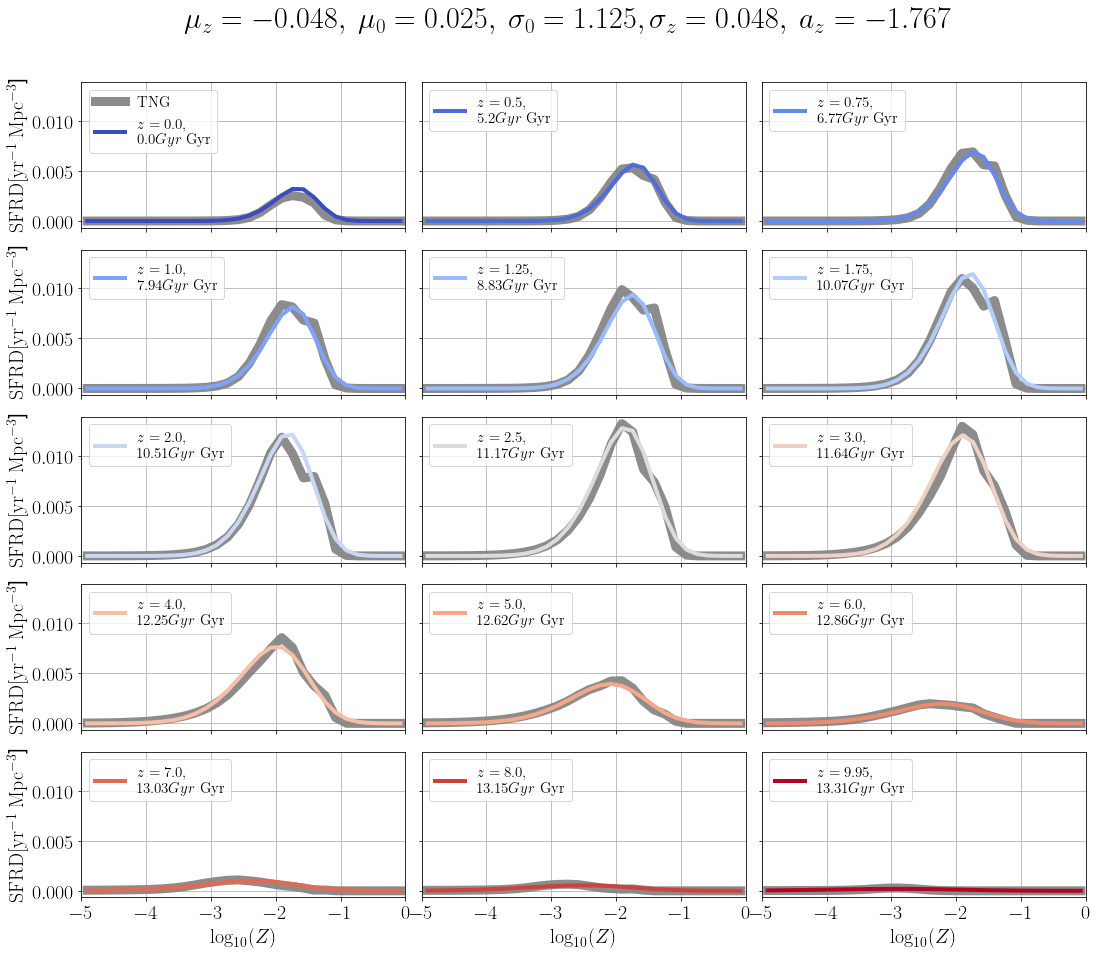

In [133]:

######################################
# BEST FITTING PARAMETERS:
print('\nBEST FITTING PARAMETERS:')
print('muz=%s, mu0=%s, sigma_0 =%s, sigma_z =%s, alpha=%s'% (muz_best, mu0_best, sigma0_best, sigmaz_best,alpha_best) )
print('\n')

######################################
normed = False

interpolated = True

######################################
if interpolated:
    # Use interpolated TNG
    print('Using interpolated TNG data')
    obs_redshift = z_new
    obs_metal = ynew
    obs_SFRD = SFRDnew.T
    redsfift_indces = [0,10,15,
                       20,25,35,
                       40,50,60,
                       80,100,120,
                       140,160,199]
else:
    # Use original TNG
    print('Using original TNG data')
    obs_redshift = redshifts_TNG[::-1]
    obs_metal = tofit_TNG_metals
    obs_SFRD = tofit_TNG_SFRD
    redsfift_indces = [0,8,15,32,40,48,58,60,66,70,75,80,88,91,95]


#####################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=obs_metal, redsh = obs_redshift)
t_lookback = cosmo.lookback_time(redshifts)
# print(['%.2f'% (z_fl) for  z_fl in redshifts ] )


#####################################
# Get the SFR
# sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 
# coen Madau_Dickinson2014(redshift_list,a=0.01, b=2.77, c=2.9, d=4.7 label = 'Neijssel et al 2019')
# sfr = Star_form

#####################################

colors     = plt.cm.coolwarm(np.linspace(0.,1.0, len(redsfift_indces))) #3rd num is the number of colours

######################################
# PLOT it!
# Draw the figure
FIG, ax = plt.subplots(nrows=5,ncols=3, figsize=(18,15), squeeze=False, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.15)#(20,28)

for z, redshift_i in enumerate(redsfift_indces):
    linestyles = ['-', ':', '--', '-.', ':']
    ######################################
    # "OBSERVATIONS" = TNG 
    ######################################
    row  = int(floor(z/3) )
    col  = z - row*3
    #print('row, col', row, col)
    
    if z == 0:
        LAB = "$\mathrm{TNG}$"
    else:
        LAB = None
    
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        obs_norm        = np.sum(obs_SFRD[redshift_i,:])
        normed_TNG_SFRD = obs_SFRD[redshift_i,:]/obs_norm
        ax[row,col].plot(np.log10(obs_metal), normed_TNG_SFRD, 
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB)   
        
    # Plot the full fit, including params for SFR(z)
    else:
        ax[row,col].plot(np.log10(obs_metal), obs_SFRD[redshift_i,:] ,
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB)    

    ######################################
    # MODEL = dPdlnZ * sfr(z)
    ######################################
    # Now the SFRD = sfr x dPdZ/p_draw_metallicity
    SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:] # Msun year-1 Mpc-3 

    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        # model is normed in log space, so multiply by log binwidth
        model = dPdlogZ[redshift_i,:] *step_logZ 
        ax[row,col].plot(np.log10(metallicities), model, lw = 4, ls = linestyles[0], c = colors[z],
                 label = "$z=%s,$ \n$%s$ $\mathrm{Gyr}$"%(np.round(redshifts[redshift_i],2), np.round(t_lookback[redshift_i],2) ) )    
    
    # Plot the full fit, including params for SFR(z)
    else:
        print('sfr[redshift_i]',sfr[redshift_i])
        ax[row,col].plot(np.log10(metallicities), SFRD, lw = 4, ls = linestyles[0], c = colors[z],
             label = "$z=%s,$ \n$%s$ $\mathrm{Gyr}$"%(np.round(redshifts[redshift_i],2), np.round(t_lookback[redshift_i],2) ) )    

    ax[row,col].legend(fontsize = 15, loc='upper left')
    ax[row,col].grid()
    
    ax[row,col].set_xlim(-5, 0.)

# #########################################
#PlotValues
for x in ax.flat:
    x.set(xlabel='$\log_{10}(Z)$', ylabel='$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for x in ax.flat:
    x.label_outer()
    
title = '$\mu_z=%s, \ \mu_0=%s, \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(muz_best,3),np.round(mu0_best,3),np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )
plt.suptitle(title, y = 0.95)

plt.show()


# at fixed metallicity


BEST FITTING PARAMETERS:
muz =-0.048244647721407255, mu0 =0.024667742078400792, sigma0 =1.1253850972905333,sigmaz =0.048072863682492945, alpha=-1.7671626767422142


Using interpolated TNG data
obs_metal [-4.90872016 -4.7420535  -4.57538683 -4.40872016 -4.2420535  -4.07538683
 -3.90872016 -3.7420535  -3.57538683 -3.40872016 -3.2420535  -3.07538683
 -2.90872016 -2.7420535  -2.57538683 -2.40872016 -2.2420535  -2.07538683
 -1.90872016 -1.7420535  -1.57538683 -1.40872016 -1.2420535  -1.07538683
 -0.90872016 -0.7420535  -0.57538683 -0.40872016 -0.2420535  -0.07538683]
(200,) (30,) (30, 200)


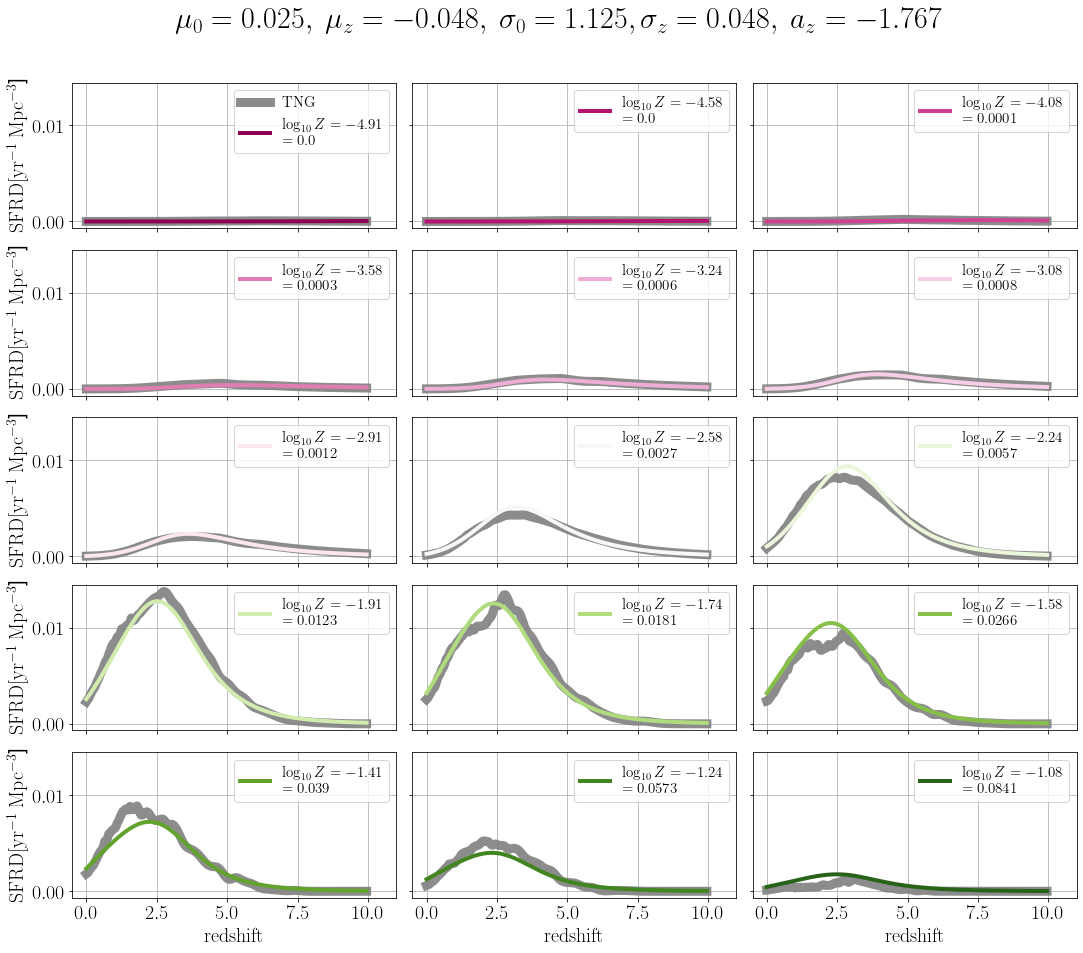

In [134]:

######################################
# BEST FITTING PARAMETERS:

print('\nBEST FITTING PARAMETERS:')
print('muz =%s, mu0 =%s, sigma0 =%s,sigmaz =%s, alpha=%s'% (muz_best,mu0_best,sigma0_best,sigmaz_best,alpha_best) )
print('\n')

######################################
normed       = False
interpolated = True

######################################
if interpolated:
    # Use interpolated TNG
    print('Using interpolated TNG data')
    obs_redshift = z_new
    obs_metal = ynew
    obs_SFRD = SFRDnew.T
    print('obs_metal' , np.log10(obs_metal) )
    print(np.shape(z_new), np.shape(ynew), np.shape(SFRDnew) )
#     metallicity_indces = [30, 32, 34, 36, 38, 40,42,44,46,48,50,52,54,56,58]
    metallicity_indces = [0,2,5,8,10,11,12,14,16,18,19,20,21,22,23]
    
else:
    # Use original TNG
    print('Using original TNG data')
    obs_redshift = redshifts_TNG[::-1]
    obs_metal = tofit_TNG_metals
    obs_SFRD = tofit_TNG_SFRD
    metallicity_indces = [0,2,5,8,10,11,12,14,16,18,19,20,21,22,23]

######################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=obs_metal, redsh = obs_redshift)

#####################################
# Get the SFR
sfr = Madau_Dickinson2014(obs_redshift, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 


#####################################
colors     = plt.cm.PiYG(np.linspace(0.,1.0, len(metallicity_indces))) #3rd num is the number of colours

######################################
# PLOT it!
# Draw the figure
FIG, ax = plt.subplots(nrows=5,ncols=3, figsize=(18,15), squeeze=False, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.15)#(20,28)

for Z, metal_i in enumerate(metallicity_indces):

    linestyles = ['-', ':', '--', '-.', ':']
    row  = int(floor(Z/3) )
    col  = Z - row*3
    #print('row, col', row, col)
    
    if Z == 0:
        LAB = "$\mathrm{TNG}$"
    else:
        LAB = None
    
    ######################################
    # "OBSERVATIONS" = TNG np.log10(
    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        obs_norm        = np.sum(obs_SFRD[:,:], axis = -1)
        ax[row,col].plot(obs_redshift, obs_SFRD[:,metal_i]/obs_norm,
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB) 
    # Plot the full fit, including params for SFR(z)
    else:
        ax[row,col].plot(obs_redshift, obs_SFRD[:,metal_i],
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB) 
        
    ######################################
    # MODEL = dPdlnZ * sfr(z)
    ######################################
    # Now the SFRD = sfr x dPdZ/p_draw_metallicity
    SFRD = sfr *dPdlogZ[:, metal_i]# Msun year-1 Mpc-3 

    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        # model is normed in log space, so multiply by log binwidth
        ax[row,col].plot(obs_redshift, dPdlogZ[:,metal_i] *step_logZ , lw = 4, ls = linestyles[0], c = colors[Z],
                 label = "$\log_{10}Z=%s$ \n $=%s$"%(np.round(np.log10(metallicities[metal_i]),2),np.round(metallicities[metal_i],4) ) )    
    else:
        ax[row,col].plot(obs_redshift, SFRD.value, lw = 4, ls = linestyles[0], c = colors[Z],
                 label = "$\log_{10}Z=%s$ \n $=%s$"%(np.round(np.log10(metallicities[metal_i]),2),np.round(metallicities[metal_i],4) ) )    
        
        
    ######################################
    # PLOT PARAMS
    ax[row,col].legend(fontsize = 15, loc='upper right')
    ax[row,col].grid()
    
    ax[row,col].set_xlim(-0.5, 11)
#     ax[row,col].set_ylim(0, 0.015)
#     ax[row,col].set_ylim(-10, -1)

# #########################################
#PlotValues
for x in ax.flat:
    x.set(xlabel='$\mathrm{redshift}$', ylabel='$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for x in ax.flat:
    x.label_outer()
    
title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )
plt.suptitle(title, y = 0.95)

plt.show()


# Plotting for presentation

 sf_a_best=0.01687063881834458, sf_b_best=1.4834054063851878, sf_c_best=4.448574027958166, sf_d_best=5.903964702985274
(200,) (100,) (100, 200)
Using interpolated TNG
saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/RedshiftMetal_Planefid.pdf


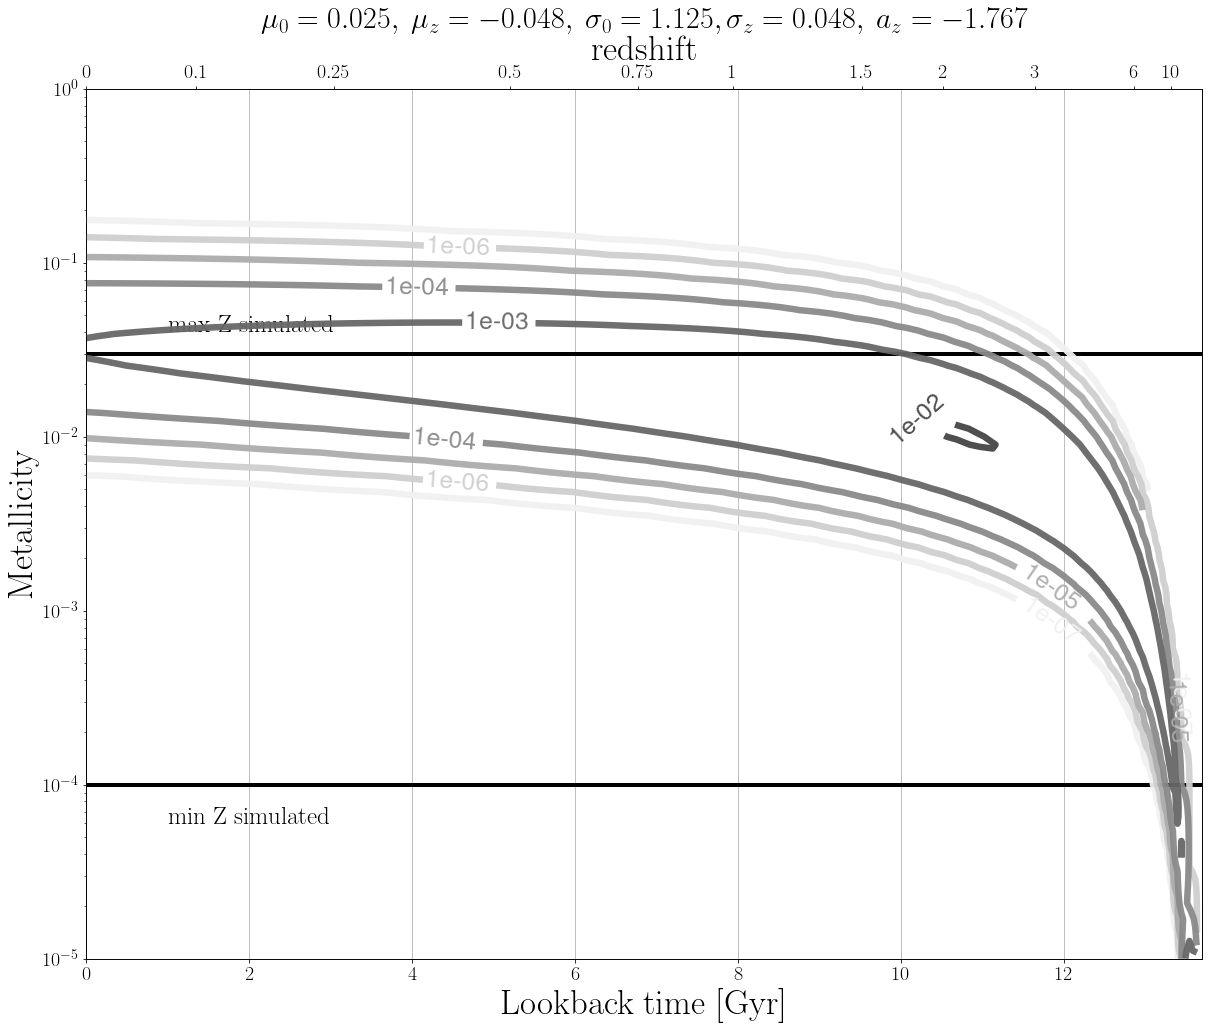

[ 0.          0.13658183  0.34030755  0.47534677  0.67671578  0.81015547
  1.00908311  1.14086723  1.33726997  1.46734342  1.66113951  1.85333323
  1.98055833  2.17001919  2.29539695  2.48204963  2.66698266  2.78930339
  2.97131465  3.15154078  3.27068859  3.50654754  3.62324616  3.79673883
  3.96834817  4.08169918  4.25012997  4.41663168  4.58118943  4.74378927
  4.90441867  5.06306637  5.21972221  5.37437747  5.52702452  5.72741947
  5.87535873  6.02127386  6.16516285  6.35386192  6.49302243  6.67542177
  6.80986482  6.98598935  7.11574095  7.28563467  7.45199472  7.61484448
  7.73469408  7.9301221   8.08261116  8.2317124   8.3774625   8.51990058
  8.69335341  8.82849234  8.99296052  9.15256312  9.30739418  9.5163257
  9.60313002  9.77192662  9.90779402 10.06523313 10.21673004 10.36246384
 10.52544101 10.68109903 10.82971687 10.97156926 11.12574783 11.27183568
 11.42698945 11.57291435 11.66532162 11.8666728  11.99903094 12.1225202
 12.27072847 12.34513494 12.44530365 12.52964511 12.6

In [196]:
######################################
# BEST FITTING PARAMETERS:
# (sfr: Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2)
####################################################
# Get dPdZ   

#NEIJSSEL
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=0.035, muz=-0.23,alpha = 0, 
                                              sigma_0=0.39, sigma_z =0, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=ynew, redsh = redshifts_TNG[::-1])
# and the SFR
sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.77, c=2.9,  d=4.7) # Msun year-1 Mpc-3 


# # Updated
# dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
#                 skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
#                                               sigma_0=sigma0_best, sigma_z =sigmaz_best, 
#                                               min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
#                                               metals=tofit_TNG_metals, redsh = redshifts_TNG[::-1])
# # and the SFR
# sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 


print(' sf_a_best=%s, sf_b_best=%s, sf_c_best=%s, sf_d_best=%s'%(sf_a_best, sf_b_best, sf_c_best, sf_d_best))

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)


#####################################
MSSFR = dPdlogZ.T *sfr
MSSFR = MSSFR.value
#/p_draw_metallicity # Msun year-1 Mpc-3 



Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )

print(np.shape(xnew), np.shape(ynew), np.shape(SFRDnew))

# print(t_lookback,  metallicities, MSSFR.value)
metal_contours_TNG(x = t_lookback.value, y = metallicities, z =MSSFR, 
                   add_TNG = False, plot_contours = True, scatter = False, BBHcontour=False,
                   show_boundaries = True, boundkleur = 'k',
                   obs_redshift = xnew, obs_metal = ynew, obs_SFRD = SFRDnew,
#                    COMPASkleur="light:#fe1100", title = Title)
                   
                   COMPASkleur="light:#000000", title = Title)

print(t_lookback, metallicities, np.amax(SFRDnew.T) )

# MSSFR compared to TNG

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


 sf_a_best=0.01687063881834458, sf_b_best=1.4834054063851878, sf_c_best=4.448574027958166, sf_d_best=5.903964702985274
(200,) (30,) (30, 200)
Using interpolated TNG
saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/RedshiftMetal_Planefid.pdf


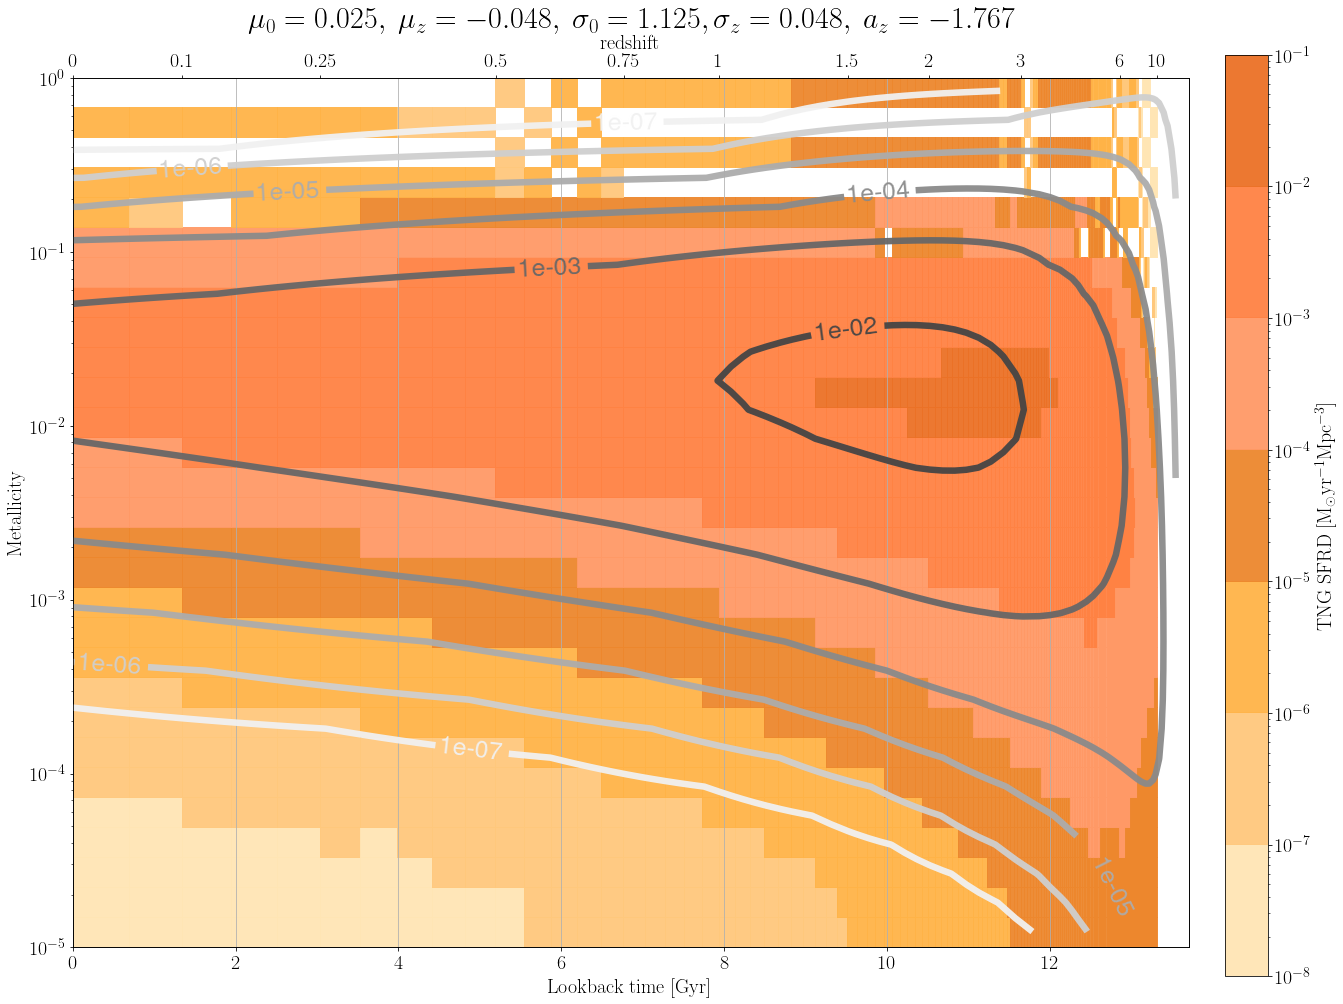

[ 0.          0.13658183  0.34030755  0.47534677  0.67671578  0.81015547
  1.00908311  1.14086723  1.33726997  1.46734342  1.66113951  1.85333323
  1.98055833  2.17001919  2.29539695  2.48204963  2.66698266  2.78930339
  2.97131465  3.15154078  3.27068859  3.50654754  3.62324616  3.79673883
  3.96834817  4.08169918  4.25012997  4.41663168  4.58118943  4.74378927
  4.90441867  5.06306637  5.21972221  5.37437747  5.52702452  5.72741947
  5.87535873  6.02127386  6.16516285  6.35386192  6.49302243  6.67542177
  6.80986482  6.98598935  7.11574095  7.28563467  7.45199472  7.61484448
  7.73469408  7.9301221   8.08261116  8.2317124   8.3774625   8.51990058
  8.69335341  8.82849234  8.99296052  9.15256312  9.30739418  9.5163257
  9.60313002  9.77192662  9.90779402 10.06523313 10.21673004 10.36246384
 10.52544101 10.68109903 10.82971687 10.97156926 11.12574783 11.27183568
 11.42698945 11.57291435 11.66532162 11.8666728  11.99903094 12.1225202
 12.27072847 12.34513494 12.44530365 12.52964511 12.6

In [107]:
######################################
# BEST FITTING PARAMETERS:
####################################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=tofit_TNG_metals, redsh = redshifts_TNG[::-1])

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)

#####################################
# Get the SFR
# Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2
print(' sf_a_best=%s, sf_b_best=%s, sf_c_best=%s, sf_d_best=%s'%(sf_a_best, sf_b_best, sf_c_best, sf_d_best))
# sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 
sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 

MSSFR = sfr*dPdlogZ.T
#/p_draw_metallicity # Msun year-1 Mpc-3 

color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'


Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )

print(np.shape(xnew), np.shape(ynew), np.shape(SFRDnew))

# print(t_lookback,  metallicities, MSSFR.value)
metal_contours_TNG(x = t_lookback.value, y = metallicities, z =MSSFR.value, plot_contours = True,
                   obs_redshift = xnew, obs_metal = ynew, obs_SFRD = SFRDnew,
                   COMPASkleur="light:#000000", title = Title)

print(t_lookback, metallicities, np.amax(SFRDnew.T) )

In [139]:

def metal_contours_TNG(x = None, y = None, z = None, normed = False,
                                tmin = 0.0, tmax = 13.7, 
                                obs_redshift = [], obs_metal = [], obs_SFRD = [],
                                DCO= None, DCO_mask = None, W_i = None,
                                param1 = 'fWR', p1 = 1.0, param2 = 'coolWind', p2 =1.0,
                                redshift_list = np.linspace(0,10, num=100),
                                boundkleur = 'orange',COMPASkleur = 'Oranges', 
                                TNGkleur = 'YlGnBu', scatterKleur = 'RdYlGn_r', BBH_kleur = 'magma',
                                title = '', savestr ='fid',
                                min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03),
                                add_TNG = True, plot_contours = True, scatter = False, BBHcontour=False,
                                show_boundaries = False, show_obs = False, fid_contours=False):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    redshift_list       ---------------> redshifts to use for SFR
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    # Create the Figure
    fig, ax = plt.subplots(figsize = (20,16))
    
    ##############################################################################

    ######################################
    if len(obs_SFRD) == 0:
        print('Using original TNG')
        with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
            MetalBins     = 10**f["MetalBins"][:]
            Lookbacktimes = f["Lookbacktimes"][:]
            BoxSfr        = f["Sfr"][:]

        # Take the centers of the metallicity bins
        center_Zbin = np.log10((MetalBins[:-1] + MetalBins[1:])/2. )

        # Convert SFR from sfr/box to sfr Mpc-3
        littleh = 0.6774
        Rbox    = 75/littleh
        cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
        cosmic_SFR = cosmic_SFR.value
        cosmic_SFR = cosmic_SFR.T

    else:
        print('Using interpolated TNG')
        Lookbacktimes = obs_redshift
        center_Zbin   = obs_metal
        cosmic_SFR    = obs_SFRD
        
    if add_TNG:
        # construct cmap
        # orange - pink - green
    #     flatui = ['#dfe6cf', '#83AF9B','#C8C8A9','#F9CDAD','#FC9D9A','#F26B38','#de531f']

        flatui = ['#ffe5b4','#ffc87c', '#ffb347', '#ed872d', '#ff9966','#ff8243',  '#eb7126']#,'#e2725b']#'#ff8f00', '#e86100']
    #     flatui = ['#c9d4d6', '#b1bbbd', '#959fa1','#7b8385','#616769','#464b4d','#313638']
        tng_color = ListedColormap(sns.color_palette(flatui).as_hex())

        TNG = ax.pcolormesh(Lookbacktimes, center_Zbin, cosmic_SFR, 
                            rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                            cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height],
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  


    ##############################################################################
    # YOUR dP/dZ MODEL
    ##############################################################################
    if plot_contours:
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        COMPAS_cmap = sns.color_palette(COMPASkleur, as_cmap=True)
        
        cs = ax.contour(x, y, z, levels, linewidths=6.5, cmap=COMPAS_cmap,
                         locator=ticker.LogLocator(), alpha = 0.95, zorder=10)
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')


    ##############################################################################
    # COMPA fiducial
    ##############################################################################
    if fid_contours:
        # Get dPdZ   
        fid_dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                        skew_metallicity_distribution(mu_0=0.035, muz=-0.23,alpha = 0, 
                                                      sigma_0=0.39, sigma_z =0, 
                                                      min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                                      metals=[], redsh = [])
        #Convert redshift to lookback time
        t_lookback = cosmo.lookback_time(redshifts)
        #####################################
        # Get the SFR Neijssel et al 2019: a=0.01, b=2.6, c=3.2,  d=6.2
        print(' sf_a_best=%s, sf_b_best=%s, sf_c_best=%s, sf_d_best=%s'%(sf_a_best, sf_b_best, sf_c_best, sf_d_best))
        fid_sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
        fid_MSSFR = fid_sfr*fid_dPdlogZ.T
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        fidCOMPAS_cmap = sns.color_palette("Blues", as_cmap=True)
        
        cs = ax.contour(t_lookback, metallicities, fid_MSSFR, levels, linewidths=3.5, cmap=fidCOMPAS_cmap,
                         locator=ticker.LogLocator(), alpha = 0.95, )
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')

        
        
    ##############################################################################
    if show_boundaries:
        ######################################
        ## Show boundaries of COMPAS
        ax.hlines(np.e**min_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**min_logZ_COMPAS -4e-5, '$\mathrm{min \ Z \ simulated}$', color = boundkleur, size =25)

        ax.hlines(np.e**max_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**max_logZ_COMPAS+1e-2, '$\mathrm{max \ Z \ simulated}$', color = boundkleur, size =25)

    ##############################################################################
    if show_obs:
        obs_col = 'orange'
        ## Zsun
        ax.hlines(0.014*1.1, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, 0.014*1.1, '$Z=Z_{\odot}$', color = obs_col, va='bottom',size =25)

        ## LMC
        ax.hlines(0.014/2., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/2.)*1.1, '$\mathrm{LMC}$', color = obs_col, va='bottom', size =25)

        ## SMC
        ax.hlines(0.014/5., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/5.)*1.1, '$\mathrm{SMC}$', color = obs_col, va='bottom',size =25)

        ## Zw18
        ax.hlines(0.014/50., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/50.)*1.1, '$\mathrm{1 \ Zw \ 18}$', color = obs_col, va='bottom', size =25)
    ######################################
    # Scatter the mergning BBHs assuming they all merge at z = 0
    # from Myr to Gyr
    if scatter:
        DCO_mask = DCO_mask#*one_CE
        BBH = DCO[DCO_mask]
        Weight_mask = W_i > 1e-10
        print(len(BBH))
        scat = ax.scatter(BBH['tDelay'][Weight_mask]*1e-3, BBH['Metallicity@ZAMS(1)'][Weight_mask], 
                   label = 'COMPAS '+param1+str(p1)+param2+str(p2), s = W_i[Weight_mask]*300,
                   c=BBH['M_moreMassive'][Weight_mask], cmap = 'RdYlGn_r' ,vmin =2.5, vmax = 45)
        
        cbaxes1 = fig.add_axes([0.125, 0.0,0.8 , 0.02]) #[left, bottom, width, height],
        cb = plt.colorbar(scat, cax = cbaxes1, label='$M_{\mathrm{BH},1}$', orientation = 'horizontal')  
        #                facecolors='none', edgecolors=kleur) 
        ax.legend(loc ='lower left',markerscale=1)

    
#     ###################
#     #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_yscale('log')
    ax.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 35)
    ax.set_ylabel('$\mathrm{Metallicity}$', fontsize = 35)
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
    # Find loockback location for each of our ages
    z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]
    
    # And annotate the tick labels :)
    ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
    ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
    ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 35)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-5, 1e0)
    
    plt.title(title)
    print('saving here', save_loc + 'RedshiftMetal_Plane'+savestr+'.pdf')
#     plt.savefig(save_loc + 'RedshiftMetal_Plane'+savestr+'.jpg',  bbox_inches='tight')
    
    plt.show()


# Same but in redshift space

In [199]:
                         
def metal_contours_TNG_zspace(x = None, y = None, z = None, normed = False,
                                tmin = 0.0, tmax = 13.7,
                              obs_redshift = [], obs_metal = [], obs_SFRD = [],
                                DCO= None, DCO_mask = None, W_i = None,
                                param1 = 'fWR', p1 = 1.0, param2 = 'coolWind', p2 =1.0,
                                redshift_list = np.linspace(0,10, num=100),
                                boundkleur = 'orange',COMPASkleur = 'Oranges', 
                                TNGkleur = 'YlGnBu', scatterKleur = 'RdYlGn_r', BBH_kleur = 'magma',
                                title = '', savestr ='fid',
                                min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03),
                                add_TNG = True, plot_contours = True, scatter = False, BBHcontour=False,
                                show_boundaries = False, show_obs = False):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    redshift_list       ---------------> redshifts to use for SFR
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    ######################################
    # Create the Figure
    fig, ax = plt.subplots(figsize = (20,16))
    
    ##############################################################################
    if add_TNG:
        ######################################
        if len(obs_SFRD) == 0:
            print('Using original TNG')
            with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
                MetalBins     = 10**f["MetalBins"][:]
                Lookbacktimes = f["Lookbacktimes"][:]
                BoxSfr        = f["Sfr"][:]

            # Take the centers of the metallicity bins
            center_Zbin = np.log10(np.log10((MetalBins[:-1] + MetalBins[1:])/2. ) )

            # Convert SFR from sfr/box to sfr Mpc-3
            littleh = 0.6774
            Rbox    = 75/littleh
            cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
            cosmic_SFR = cosmic_SFR.value
            cosmic_SFR = cosmic_SFR.T
            
            #### TNG redshifts corresponding to these lookback times ### 
            # the last value of Lookbacktimes = 0, which is problematic for z calculation
            redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
            redshifts_TNG.append(0) # put redshift zero back at the end
            redshifts_TNG = np.array(redshifts_TNG)        

        else: 
            print('Using interpolated TNG')
            redshifts_TNG = obs_redshift
            center_Zbin   = obs_metal
            cosmic_SFR    = obs_SFRD    
            ax.set_yscale('log')
            
            
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed:
        norm_cosmic_SFR = np.sum(cosmic_SFR, axis = -1)
        cosmic_SFR = cosmic_SFR/norm_cosmic_SFR[:,np.newaxis]  
    
    # construct cmap
    flatui = ['#dfe6cf', '#83AF9B','#C8C8A9','#F9CDAD','#FC9D9A','#F26B38','#de531f']
    #Oranges
    flatui = ['#ffe5b4','#ffc87c', '#ffb347', '#ed872d', '#ff9966','#ff8243',  '#eb7126']#,'#e2725b']#'#ff8f00', '#e86100']

    tng_color = ListedColormap(sns.color_palette(flatui).as_hex())

    if add_TNG:
        TNG = ax.pcolormesh(redshifts_TNG, center_Zbin, cosmic_SFR, 
                            rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                            cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height],
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  


    ##############################################################################
    if plot_contours:
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        COMPAS_cmap = sns.color_palette(COMPASkleur, as_cmap=True)

        cs = ax.contour(x, y, z, levels, linewidths=6.5, cmap=COMPAS_cmap)
#                          locator=ticker.LogLocator(), alpha = 0.95, )
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')


    ##############################################################################
    if show_boundaries:
        ######################################
        ## Show boundaries of COMPAS
        ax.hlines(np.e**min_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**min_logZ_COMPAS -4e-5, '$\mathrm{min \ Z \ simulated}$', color = boundkleur, size =25)

        ax.hlines(np.e**max_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**max_logZ_COMPAS+1e-2, '$\mathrm{max \ Z \ simulated}$', color = boundkleur, size =25)

    ##############################################################################
    if show_obs:
        obs_col = 'orange'
        ## Zsun
        ax.hlines(0.014*1.1, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, 0.014*1.1, '$Z=Z_{\odot}$', color = obs_col, va='bottom',size =25)

        ## LMC
        ax.hlines(0.014/2., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/2.)*1.1, '$\mathrm{LMC}$', color = obs_col, va='bottom', size =25)

        ## SMC
        ax.hlines(0.014/5., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/5.)*1.1, '$\mathrm{SMC}$', color = obs_col, va='bottom',size =25)

        ## Zw18
        ax.hlines(0.014/50., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/50.)*1.1, '$\mathrm{1 \ Zw \ 18}$', color = obs_col, va='bottom', size =25)
    
    ######################################
    # Scatter the mergning BBHs assuming they all merge at z = 0
    # from Myr to Gyr
    if scatter:
        DCO_mask = DCO_mask#*one_CE
        BBH = DCO[DCO_mask]
        Weight_mask = W_i > 1e-10
        print(len(BBH))
        scat = ax.scatter(BBH['tDelay'][Weight_mask]*1e-3, BBH['Metallicity@ZAMS(1)'][Weight_mask], 
                   label = 'COMPAS '+param1+str(p1)+param2+str(p2), s = W_i[Weight_mask]*300,
                   c=BBH['M_moreMassive'][Weight_mask], cmap = 'RdYlGn_r' ,vmin =2.5, vmax = 45)
        
        cbaxes1 = fig.add_axes([0.125, 0.0,0.8 , 0.02]) #[left, bottom, width, height],
        cb = plt.colorbar(scat, cax = cbaxes1, label='$M_{\mathrm{BH},1}$', orientation = 'horizontal')  
        #                facecolors='none', edgecolors=kleur) 
        ax.legend(loc ='lower left',markerscale=1)

    
    ###################
    #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_xlabel('$\mathrm{redshift}$', fontsize = 40)
    ax.set_ylabel('$\mathrm{Metallicity}$', fontsize = 40)
    ax.set_yscale('log')
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    # Find loockback location for each of our redshifts
    redshift_tick_list = [0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
    # And annotate the tick labels :)
    ax2.set_xticks([z for z in redshift_tick_list])
    ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list])
    ax2.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 20)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-5, 1e0)
#     ax.set_ylim(-5, 0)
    
    plt.title(title)
    print('saving here', save_loc + 'RedshiftMetal_Plane'+savestr+'.pdf')
#     plt.savefig(save_loc + 'RedshiftMetal_Plane'+savestr+'.jpg',  bbox_inches='tight')
    
    plt.show()

    




# For presentation

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/RedshiftMetal_Planefid.pdf


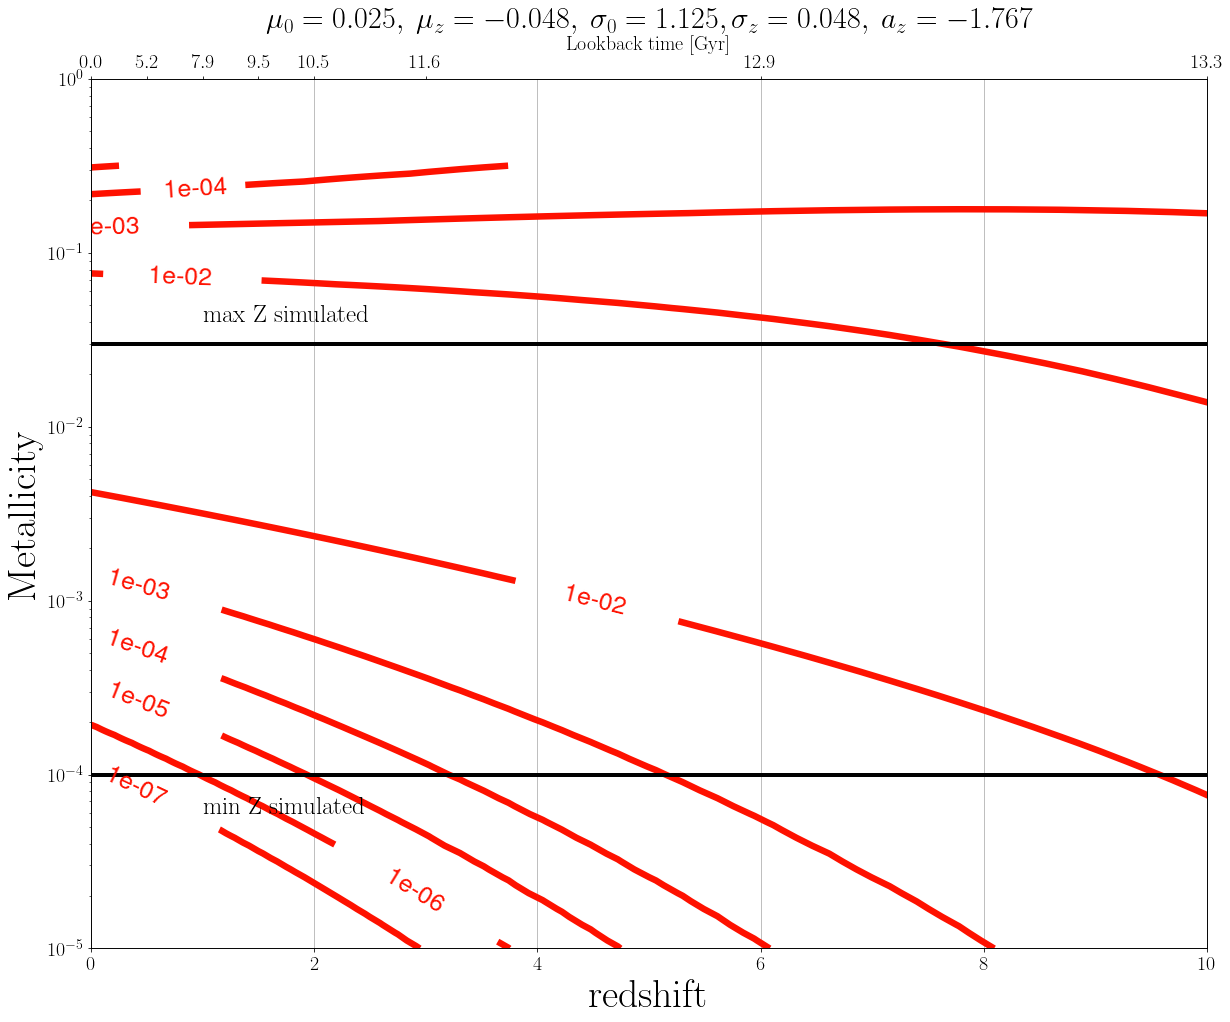

In [200]:
    
######################################
# BEST FITTING PARAMETERS:
####################################################
# Get dPdZ   

# #NEIJSSEL
# dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
#                 skew_metallicity_distribution(mu_0=0.035, muz=-0.23,alpha = 0, 
#                                               sigma_0=0.39, sigma_z =0, 
#                                               min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
#                                               metals=ynew, redsh = redshifts_TNG[::-1])
# # and the SFR
# sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.77, c=2.9,  d=4.7) # Msun year-1 Mpc-3 


# Updated
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=ynew, redsh = redshifts_TNG[::-1])
# and the SFR
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)


#####################################
MSSFR = dPdlogZ.T #*sfr
# MSSFR = MSSFR.value
#/p_draw_metallicity # Msun year-1 Mpc-3 

#####
color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'
Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )

metal_contours_TNG_zspace(x = redshifts, y = metallicities, z = MSSFR, 
                          add_TNG=False, plot_contours = True, scatter = False, 
                           show_boundaries = True, boundkleur = 'k',
                          BBHcontour=False,show_obs = False,
                          title = Title, tmin = 0.0, tmax = 10.,COMPASkleur = 'light:#fe1100_r', 
                          obs_redshift = z_new, obs_metal = ynew, obs_SFRD = SFRDnew,normed = False)



/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Using interpolated TNG
saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/RedshiftMetal_Planefid.pdf


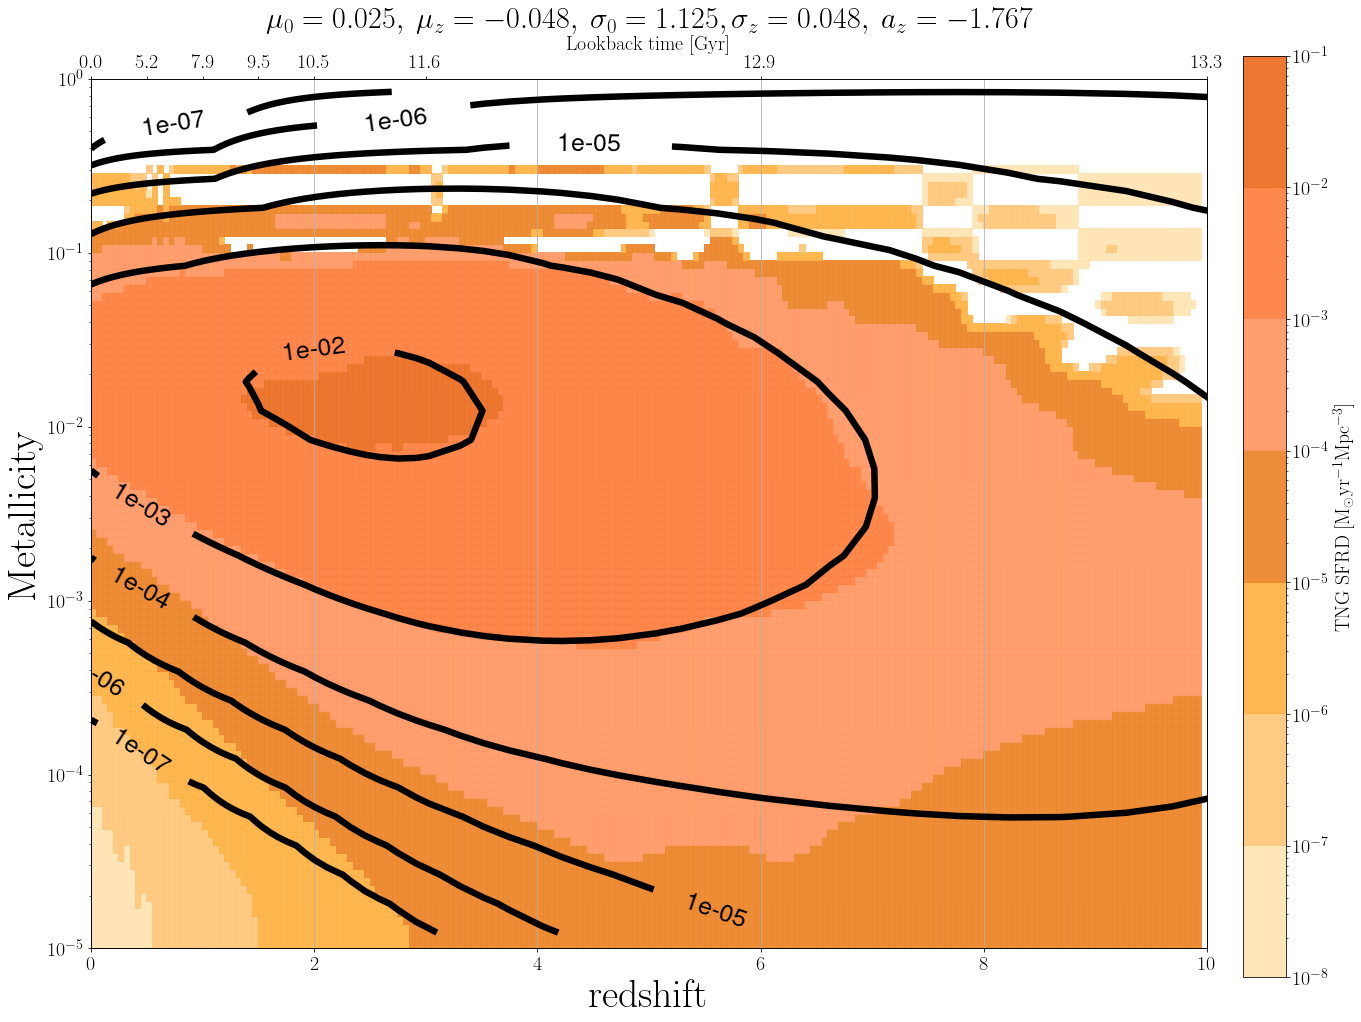

In [201]:
    
######################################
# BEST FITTING PARAMETERS:
####################################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=tofit_TNG_metals, redsh = redshifts_TNG[::-1])
#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)

#####################################
# Get the SFR
# Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 

MSSFR = sfr*dPdlogZ.T
#/p_draw_metallicity # Msun year-1 Mpc-3 

#####
color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'
Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )

metal_contours_TNG_zspace(x = redshifts, y = metallicities, z = MSSFR.value, add_TNG=True,
                          title = Title, tmin = 0.0, tmax = 10.,COMPASkleur = 'Greys_r', 
                          obs_redshift = z_new, obs_metal = ynew, obs_SFRD = SFRDnew,
                          plot_contours = True, normed = False)

# metal_contours_TNG_zspace(x = redshifts, y = metallicities, z =MSSFR ,savestr ='0.15',
#                         kleur = color_pallette,  title = Title, tmin = 0.0, tmax = 10.,
#                         kleurlabel = '$\mathrm{SSFRD \ [M_{\odot} \ Gpc^{-3}\ yr^{-1}]}$',
#                         plot_contours = True, normed = False)


max value of dPdlogZ 3.5007383759422166


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: The following kwargs were not used by contour: 'fontsize'


saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/RedshiftMetal_Planefit.pdf


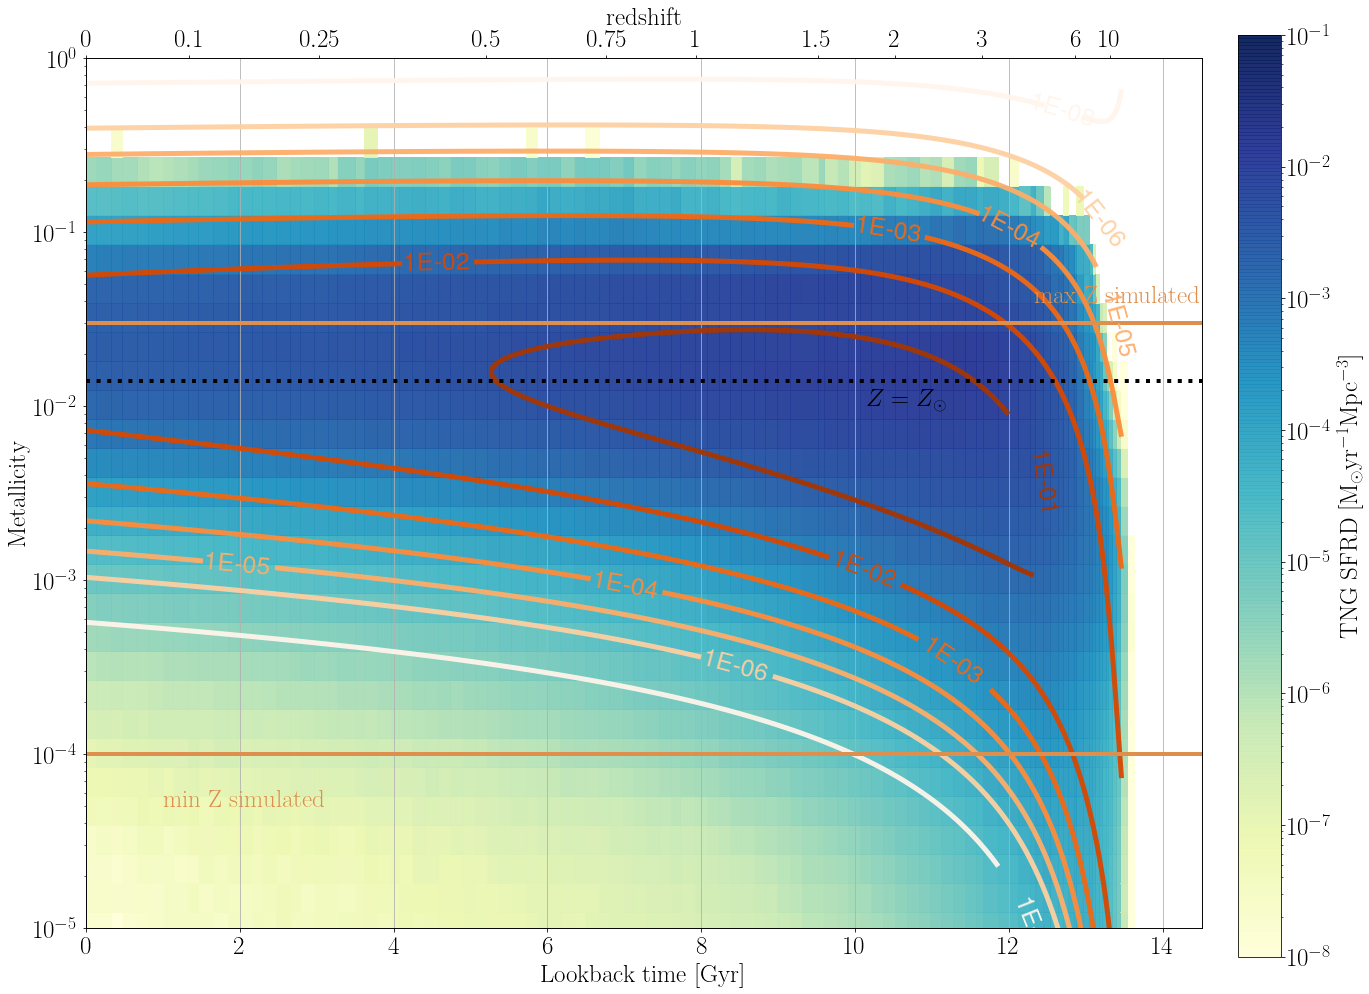

In [16]:
# Z0_fit, Pa_fit, sigma_fit, s_fact_fit = res[0]
# print('Z0_fit', np.round(Z0_fit,3), 'Pa_fit',  np.round(Pa_fit,3),
#       'sigma_fit',  np.round(sigma_fit,3), 's_fact_fit',  np.round(s_fact_fit,3) )
Z0_fit     = 0.025 # 0.025#0.035
Pa_fit     = -0.2#-0.095 #-0.23
sigma_fit  = 0.65 #0.39
s_fact_fit = 0.04#0.04


####################################################
# Get dPdZ 
dPdlogZ, redshifts, metallicities, p_draw_metallicity = get_metallicity_distribution(max_redshift = 13.0,redshift_step = 0.01,
                                 Z0=Z0_fit, alpha=Pa_fit, sigma=sigma_fit, s_factor = s_fact_fit)

print('max value of dPdlogZ', np.amax(dPdlogZ )/p_draw_metallicity )

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)

# Get the SFR
sfr = Madau_Dickinson2014(redshifts, a=0.01, d=4.7)# Msun year-1 Mpc-3 

MSSFR = sfr*dPdlogZ.T/p_draw_metallicity # Msun year-1 Mpc-3 

color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'

metal_contours_TNG(x = t_lookback, y = metallicities, z =MSSFR ,savestr ='fit', 
                   scatter=False, kleur = color_pallette, kleurlabel = '$\mathrm{MSSFR \ [M_{\odot} \ yr^{-1}]}$'+ "$Z_0=%s$, $\mu_z=%s$, $\sigma=%s$"%(Z0, Pa, sigma) )




# calculatte chi squared by hand
###  Either by supplying a range of values and just taking the minimum 
### (this means you have to do the refinement part by hand)

In [ ]:
def skew_metallicity_distribution(max_redshift = 10.0,redshift_step = 0.01,
                                  mu_0=0.035, muz=-0.23, sigma=0.39, alpha = 0.0,
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                  metals = [], redsh = [],
                                  min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03)):
                                 
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    that is basically a skew normal distribution, but then with the random variable x = ln(Z)

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu_0    = 0.035    --> [float]          location (mean in normal) for redshift 0
        muz = -0.23    --> [float]          redshift scaling of the location
        sigma   = 0.39     --> [float]          Scale (variance in normal)
        alpha   = 0.0      --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """
    import scipy
    ##################################
    # the PDF of a standard normal distrtibution
    def normal_PDF(x):
        return 1./(np.sqrt(2* np.pi)) * np.exp(-(1./2) * (x)**2 )

    ##################################
    # the CDF of a standard normal distrtibution
    def normal_CDF(x):
        return 1./2. * (1 + scipy.special.erf(x/np.sqrt(2)) )
    
    ##################################
    if len(redsh) == 0:
        # Make redshifts
        redshifts = np.arange(0, max_redshift + redshift_step, redshift_step)
    else:
        redshifts = redsh

    ##################################
    # Follow Langer & Norman in assuming that mean metallicities evolve in z as:
    mean_metallicities = 10**(muz * redshifts[:,np.newaxis])   # add an axis for muz
    mean_metallicities = mu_0 * mean_metallicities[:,:,np.newaxis] # add an axis for mu_0
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    #print(10*'*', 'BETA', beta)
    PHI  = normal_CDF(beta * sigma[:,np.newaxis]) # phi is now sigma x alpha dimentional
    #print('np.shape(PHI)', np.shape(PHI))
    #print('np.shape(mean_metallicities)', np.shape(mean_metallicities), 'np.shape(sigma)', np.shape(sigma))
    #print(np.shape(1./(np.exp(0.5*sigma[:,np.newaxis]**2) * PHI) ) ) # this is now sigma x alpha dimentional
    
    mu_metallicities = np.log(mean_metallicities[:,:,:,np.newaxis,np.newaxis]/2. * 1./(np.exp(0.5*sigma[:,np.newaxis]**2) * PHI )  ) 
    #print('np.shape(mu_metallicities)', np.shape(mu_metallicities))

    ##################################
    if len(metals) == 0:
        # create a range of metallicities (thex-values, or raandom variables)
        log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
        metallicities = np.exp(log_metallicities)
    else: 
        #use a pre-determined array of metals
        metallicities     = metals
        log_metallicities = np.log(metallicities)
        step_logZ         = np.diff(log_metallicities)
        step_logZ         = step_logZ[0]
        print('step_logZ', step_logZ)

    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    sigma_matrix = sigma[np.newaxis,np.newaxis,np.newaxis,:,np.newaxis,np.newaxis] # 1, 1,1, __sigma__, 1 ,1
    #print('np.shape(sigma_matrix)', np.shape(sigma_matrix))

    alpha_matrix = alpha[np.newaxis,np.newaxis,np.newaxis,np.newaxis,:,np.newaxis] # 1, 1,1, 1, __alpha__ ,1
    #print('np.shape(alpha_matrix)', np.shape(alpha_matrix))
    mu_matrix    = mu_metallicities[:,:,:,:,:,np.newaxis] # dimension is now redshift, mu_z,mu0, sigma, alpha + metallicity
    
    dPdlogZ = 2./(sigma_matrix) * normal_PDF((log_metallicities -  mu_matrix)/sigma_matrix) * normal_CDF(alpha_matrix * (log_metallicities -  mu_matrix)/sigma_matrix )


    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) #* step_logZ
    dPdlogZ = dPdlogZ / norm[:,:,:,:,:,np.newaxis]
    #print('NORMING', np.sum(dPdlogZ, axis = -1 )*step_logZ  )
    print('np.shape(dPdlogZ)', np.shape(dPdlogZ))

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity



In [213]:
muz_List = np.arange(-0.3, -0.05+0.01,  0.01)#np.array([-0.06, -0.07,-0.075,-0.080,-0.085, -0.09, -0.1])
mu_0_List    = np.array([0.02,0.024, 0.025,0.026,0.027,0.03])#np.arange(0.01, 0.04,  0.005)
sigma_List   = np.arange(0.5, 2.5+0.1, 0.1)#np.array([1.8, 1.85, 1.9,1.92,1.93,1.94, 1.95,1.96, 2.0,2.1])
alpha_List   = np.arange(-4, -0.5+0.1, 0.1)#np.array([-3.7, -3.65, -3.6, -3.55, -3.5,-3.4,-3.3])#np.arange(-4, -2, 0.05)


#####################################
# Get the SFR
# sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
# coen Madau_Dickinson2014(redshift_list,a=0.01, b=2.77, c=2.9, d=4.7 label = 'Neijssel et al 2019')
Star_form = Madau_Dickinson2014(redshifts, a=0.01, b=2.1, c=3.3,  d=5.6) # Msun year-1 Mpc-3 

##############################################################
# Start calculating Chi squared
##############################################################    
chi_square_matix, muz_best, mu_0_best, sigma_best, alpha_best = \
            calc_chi_square(fit_metals = tofit_TNG_metals, observed_SFRD = tofit_TNG_SFRD, 
                            redshifts = redshifts_TNG[::-1], normed=False, SFR = Star_form,
                            muz_list = muz_List, mu_0_list = mu_0_List,
                            sigma_list = sigma_List, alpha_list = alpha_List)
    
    

********** BETA [-0.9701425  -0.96866387 -0.96707454 -0.96536339 -0.96351791 -0.96152395
 -0.9593655  -0.9570244  -0.95447998 -0.95170862 -0.9486833  -0.94537298
 -0.94174191 -0.93774876 -0.93334561 -0.92847669 -0.92307692 -0.91707006
 -0.91036648 -0.90286052 -0.89442719 -0.88491822 -0.87415728 -0.86193422
 -0.8479983  -0.83205029 -0.81373347 -0.79262399 -0.76822128 -0.73994007
 -0.70710678 -0.66896473 -0.62469505 -0.57346234 -0.51449576 -0.4472136 ]
np.shape(PHI) (21, 36)
np.shape(mean_metallicities) (100, 26, 6) np.shape(sigma) (21,)
(21, 36)
np.shape(mu_metallicities) (100, 26, 6, 21, 36)
step_logZ 0.3837641821656739
np.shape(sigma_matrix) (1, 1, 1, 21, 1, 1)
np.shape(alpha_matrix) (1, 1, 1, 1, 36, 1)


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


np.shape(dPdlogZ) (100, 26, 6, 21, 36, 30)
(100, 26, 6, 21, 36, 30)
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model ha